# Fraud Data Analysis Assignment

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set(style="darkgrid",font_scale=1)
import numpy as np
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn import svm
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import Imputer
from matplotlib.lines import Line2D
from sklearn import metrics
from IPython.display import display, HTML
import warnings
warnings.filterwarnings('ignore')
from sklearn.ensemble import RandomForestClassifier
from itertools import product
from datetime import datetime
%config InlineBackend.figure_format ='retina'
from scipy.stats import beta
from sklearn.tree import DecisionTreeClassifier

In [2]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

First, import the dataset. This dataset has following columns;

* **ID**: Unique record identifier,
* **dist_latest_transaction_address_km**: Distance between the most recent transaction and place of application,
* **email**: Email address of the applicant,
* **application_date**: Application Date of the applicant,
* **site_visits_A**: No. of visits to site A,
* **site_visits_B**: No. of visits to site B,
* **site_visits_C**: No. of visits to site C,
* **credit_limit**: Credit limit of previous card,
* **number_of_transactions**: Number of transactions on most recent card,
* **is_fraud**: flag identifying an applicant as fraud or safe

In [3]:
fraud_data=pd.read_csv('fraud_data.csv')
fraud_data.shape

(65499, 10)

In [4]:
fraud_data.head(3)

,id,dist_latest_transaction_address_km,email,application_date,site_visits_A,site_visits_B,site_visits_C,credit_limit,number_of_transactions,is_fraud
0,0,11,lmeechan7i@cbsnews.com,2019-04-23 07:56:50.487770,6,0,0,"$1,941.32",22,0
1,1,1,nwarkupic@desdev.cn,2019-03-11 17:27:51.857759,36,0,0,"$1,149.98",17,0
2,2,1,dcoolpg@yolasite.com,2019-04-30 00:40:09.281798,3,1,1,"$1,613.38",14,0


## Basic Data Exploration
To begin with we will look at the distributon of column, is_fraud. It will give us an idea about class imbalance, i.e. sample bias. As seen below, the data is heavily skewed, with only 3 percent of fraud cases.


In [4]:
fraud_data['is_fraud'].value_counts(normalize=True)

0    0.961312
1    0.038688
Name: is_fraud, dtype: float64

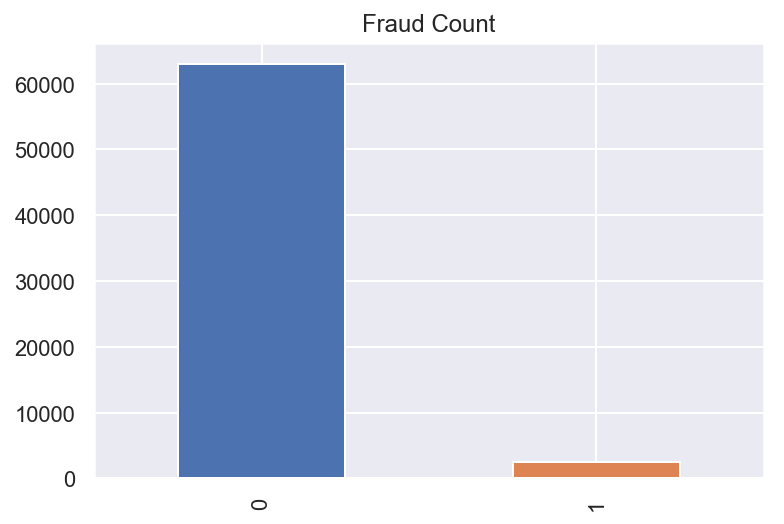

In [5]:
fraud_data.is_fraud.value_counts().plot(kind='bar', title='Fraud Count')

In [4]:
fraud_data.columns[fraud_data.isnull().any()]

Index(['email'], dtype='object')

Email is the only column having null values.Couple of questions to consider; what percent of email values are missing?Next, are the missing records showing a trend? We see below that only 30 rows in total have missing values for the email feature. Moreover, all of them are non-fraud's. Since non-frauds account for almost 95 percent of these entire dataset almost 65 K records, deleting 30 of them does not seem to be a thing of concern. Therefore, we decide to drop them. 

In [9]:
null_data = fraud_data[fraud_data.isnull().any(axis=1)]
null_data;

In [5]:
fraud_data=fraud_data.dropna()
#fraud_data[fraud_data.isnull().any(axis=1)]

Along the same lines, we observe that the features; distance of most recent applicaton and transation has a values, 'unknown', which signifies that distance between the recent application and transaction is missing. We saw that there are close to 2K records with missing values for distance. Therefore, we decide not to ignore it, and impute it with median value, since it is numeric in nature.

In [6]:
not_unknown=fraud_data[fraud_data['dist_latest_transaction_address_km']!='unknown']
median_distance=not_unknown['dist_latest_transaction_address_km'].median()

fraud_data.replace({'dist_latest_transaction_address_km':{'unknown': median_distance}},inplace=True)

Once we have taken care of the missing values, we will explore the data more to identify few variables at first sight which might help in predicting an application as fraud or safe.

### Converting Columns to Proper Data Types

Before proceeding with the EDA, it will be useful to have the features as well as response variable to be converted to proper data types.
  

In [7]:
#fraud_data.replace({'is_fraud': {0: 'No',1:'Yes'}},inplace=True)
fraud_data = fraud_data.astype({"dist_latest_transaction_address_km": int})
fraud_data['credit_limit']=fraud_data['credit_limit'].replace('[\$,]','',regex=True)\
                           .astype(float)  
fraud_data.head(2)

,id,dist_latest_transaction_address_km,email,application_date,site_visits_A,site_visits_B,site_visits_C,credit_limit,number_of_transactions,is_fraud
0,0,11,lmeechan7i@cbsnews.com,2019-04-23 07:56:50.487770,6,0,0,1941.32,22,0
1,1,1,nwarkupic@desdev.cn,2019-03-11 17:27:51.857759,36,0,0,1149.98,17,0


The above columns seem to be in proper format, numeric in nature. We have two more predictor variables; email and application date, which are still string (object) types. First, we convert the application date to datetime object. It will be useful, in the sense that we can extract different types of date as well as time information from it.  Next we will extract the domain information from the email addresses of the applicants. It has been seen that applications being submitted by certain domains tend to posess more fraudulent behavior as compared to others.

In [8]:
fraud_data['application_date']=fraud_data['application_date'].apply(lambda x:datetime.\
                                                                strptime(x,'%Y-%m-%d %H:%M:%S.%f'))
fraud_data['time']=fraud_data['application_date'].apply(lambda x:x.hour)

In [9]:
fraud_data['day']=fraud_data['application_date'].apply(lambda x:x.day)

In [10]:
fraud_data['day_name']=fraud_data['application_date'].apply(lambda x:x.weekday())

In [11]:
def replace_weekday(day):
    #print domain
    if day==0:
        return 'Mon'
    elif day==1:
        return 'Tue'
    elif day==2:
        return 'Wed'
    elif day==3:
        return 'Thu'
    elif day==4:
        return 'Fri'
    elif day==5:
        return 'Sat'
    elif day==6:
        return 'Sun'
    else:
        return day

In [12]:
fraud_data['day_name']=fraud_data['day_name'].apply(replace_weekday)

In [13]:
fraud_data = fraud_data.astype({"day_name": str})

In [14]:
fraud_data['Domain_name']=fraud_data['email'].apply(lambda x:str(x).split("@")[1])
#fraud_data['Domain_name'].head(4)

It seems, we have the features/columns in proper data types now. While working on this we also performed some sort of feature engineering, created two new columns; time (on 24 hr scale) and domain name. It is highly likely that we will construct more new features in later sections.

### Exploratory Data Analysis(EDA)
Next we can go back to our previous topic, perform Exploratory Data Analysis (EDA). To begin with, we will observe the variation of number of site visits and the site visited on a particular application day. Is it true that fraudsters visit one site more frequently on a particular day of the week. 

In [27]:
fraud_day_site_visits= fraud_data.groupby(['is_fraud','day_name']).agg({'site_visits_A':np.sum,'site_visits_B':np.sum})
fraud_day_site_visits.reset_index(['is_fraud','day_name'],drop=False,inplace=True);

In [29]:
fraud_day_site_visits['site_A_prop']=fraud_day_site_visits['site_visits_A']/(fraud_day_site_visits['site_visits_A']+fraud_day_site_visits['site_visits_B'])
fraud_day_site_visits['site_B_prop']=fraud_day_site_visits['site_visits_B']/(fraud_day_site_visits['site_visits_A']+fraud_day_site_visits['site_visits_B'])
fraud_day_site_visits.head(4);


,is_fraud,day_name,site_visits_A,site_visits_B,site_A_prop,site_B_prop
0,0,Fri,76390,8245,0.902582,0.097418
1,0,Mon,85245,9039,0.904130,0.095870
2,0,Sat,77256,8195,0.904097,0.095903
3,0,Sun,78728,8280,0.904836,0.095164


In [30]:
fraud_day_site_visits

,is_fraud,day_name,site_visits_A,site_visits_B,site_A_prop,site_B_prop
0,0,Fri,76390,8245,0.902582,0.097418
1,0,Mon,85245,9039,0.904130,0.095870
2,0,Sat,77256,8195,0.904097,0.095903
3,0,Sun,78728,8280,0.904836,0.095164
4,0,Thu,83789,8486,0.908036,0.091964
5,0,Tue,86057,9391,0.901611,0.098389
6,0,Wed,86700,9091,0.905095,0.094905
7,1,Fri,2835,296,0.905462,0.094538
8,1,Mon,3263,331,0.907902,0.092098
9,1,Sat,3460,306,0.918747,0.081253


Looking at the above table, we don't see much trend in the site visits across both groups. It is obvious that site A is much more popular amoung the users.

Next, we will define a function to perform grouping and aggregations, which will be handy later. First, we will compute the fraud percentage, at different times in the day.


In [15]:
#We write a function that will perform grouping and aggregation so as to compute
#percentage of fraud for different levels and combinations of categorical variables. 

def group_by_fraud_pct(data,s1,s2):
    #Here, data refers to the data frame.
    #s1,s2 are categorical variables used for grouping.
    #print s1,s2
    gb_fraud=data.groupby([s1,s2]).agg({'id':'count'})
    #print gb_fraud
    fraud_pct=gb_fraud.groupby(s1).apply(lambda x:100 * (x / float(x.sum())))
    pcts = fraud_pct.reset_index()
    fraud_pct=pcts[pcts[s2]==1]
    #print fraud_pct.head(4)
    fraud_pct.rename(columns={'id':'fraud_percent'},inplace=True)
    return fraud_pct

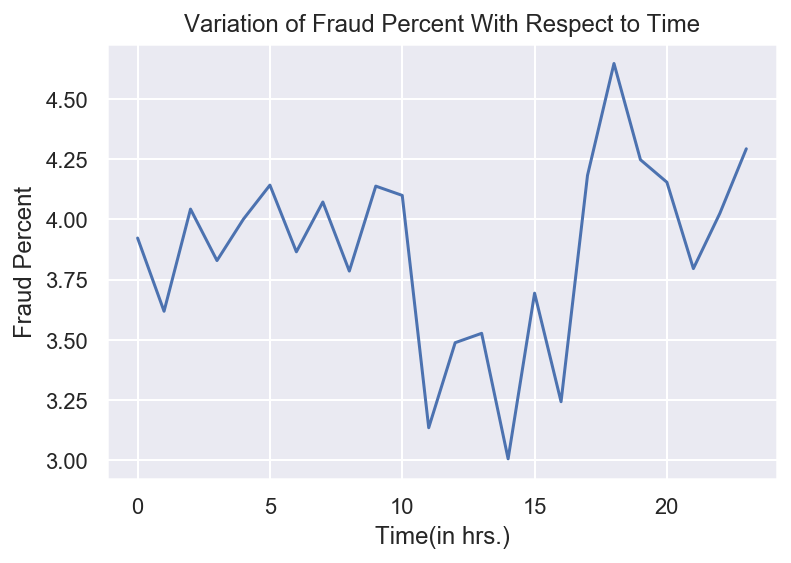

In [16]:
#Call the above defined function to find the fraud percent at a given time.

fraud_pct= group_by_fraud_pct(fraud_data,'time','is_fraud')
ax_fraud_time = sns.lineplot(x="time", y="fraud_percent", data=fraud_pct)
ax_fraud_time.set_title("Variation of Fraud Percent With Respect to Time",\
                        fontdict={'fontsize':12})
ax_fraud_time.set_xlabel("Time(in hrs.)")
ax_fraud_time.set_ylabel("Fraud Percent")
plt.show()


We are seeing a slight increase in fraud percentage around 5 to 6 p.m in the evenings. The increase is important, in the sense, that the fraud percent is low between the hours 10 a.m to 3p.m. It is worthwhile using time in the set of features used for predicting the reponse variable.
Next, we observe the variation of fraud percentage with the distance between the application of the previous card and place of transaction. It is likely that fraudulent transactions occur quite far from the home address of the card owner. One possible approach to find this relation is to divide the distance feature into intervals,(i.e. buckets) and for each bucket find the fraud percent. Binning a continuous variable helps to see pattern in data, which can be easily interpreted using bar graph.  

As a trial, we divide the column into buckets, each of length 2, so as not to have too  many buckets, at the same time, we want to get some granular information. 

In [17]:
fraud_data['group_distance']=pd.cut(fraud_data['dist_latest_transaction_address_km'],\
                                    range(0,65,2),include_lowest=True)
#Call the function, group_by_fraud_pct again to perform grouping and aggregation.

distance_fraud_pct= group_by_fraud_pct(fraud_data,'group_distance','is_fraud')
#gb_distance_fraud=distance_fraud.groupby(['group_distance','is_fraud'])\
#.agg({'id':'count'})
#distance_fraud_pct = gb_distance_fraud.groupby('group_distance')\
#.apply(lambda x:100 * x / float(x.sum()))
#distance_fraud_pct = distance_fraud_pct.reset_index()
#fraud_percent=distance_fraud_pct[distance_fraud_pct['is_fraud']=='Yes']
#fraud_percent.rename(columns={'id':'fraud_percent'},
#inplace=True)
#fraud_percent.tail(5)

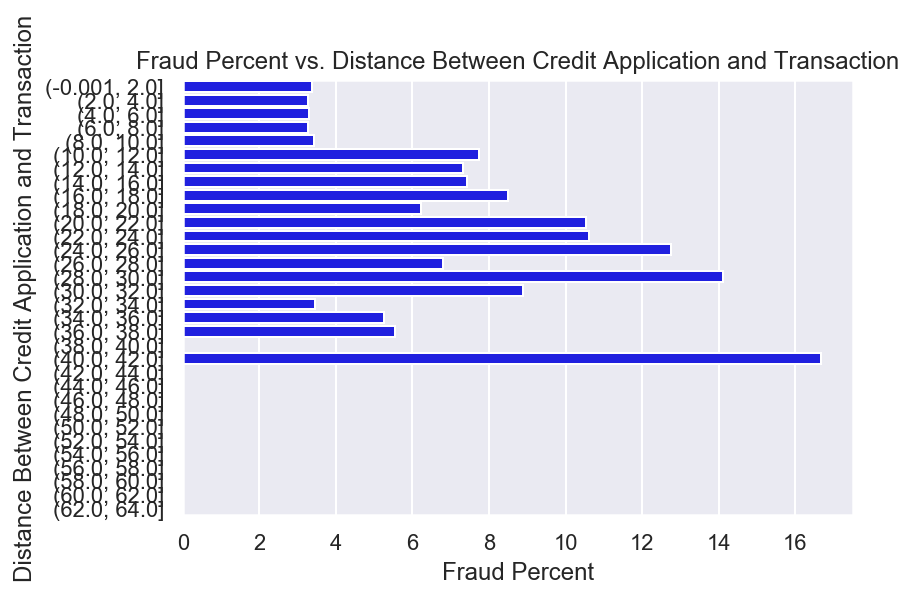

In [18]:
ax_barplot_dist = sns.barplot(x="fraud_percent", y="group_distance", \
                        data=distance_fraud_pct,orient="h",ci=None,color="blue")
ax_barplot_dist.set_title("Fraud Percent vs. Distance Between Credit Application and Transaction")
ax_barplot_dist.set_xlabel("Fraud Percent")
ax_barplot_dist.set_ylabel("Distance Between Credit Application and Transaction")
plt.show()

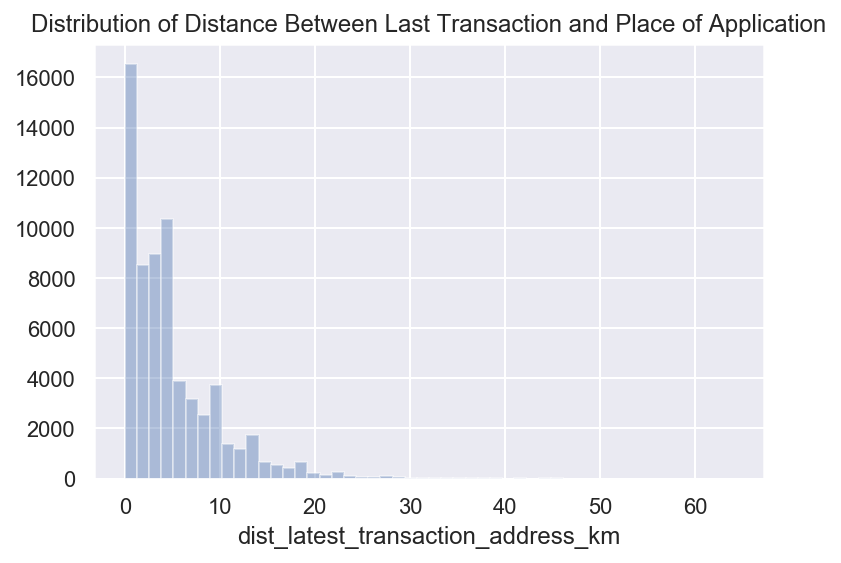

In [13]:
ax_distance=sns.distplot(fraud_data['dist_latest_transaction_address_km'],kde=False)
ax_distance.set_title("Distribution of Distance Between Last Transaction and Place of Application")
plt.show()

In [21]:
long_distance_purchases=fraud_data[(fraud_data['dist_latest_transaction_address_km']>=40) & (fraud_data['dist_latest_transaction_address_km']<=44)]
long_distance_purchases['is_fraud'].value_counts()

0    14
1     1
Name: is_fraud, dtype: int64

From the above figure, we observe that fraud cases were prevalent, when the distance between most recent credit application and transaction is large. Mostly in the range 40 through 42 km. Therefore, distance between most recent credit application and transaction seems to be a decisive factor in predicting whether a credit application is fraudulent or not.  This observation aligns with our intial assumption. Moreover, the fraud percent dropped and rose a bit towards the end, since there are only 15 observations in the distance range 40-44 km, and 1 of them was  a fraud case.

Next, we analyze the relation between fraud percentage and the domain names used by the applicant for email address. 

In [19]:
domain_fraud_pct=group_by_fraud_pct(fraud_data,'Domain_name','is_fraud')

In [27]:
fraud_data[(fraud_data['Domain_name']=='alexa.com') ].shape

(4510, 15)

In [28]:
domain_fraud_pct.head(2)

,Domain_name,is_fraud,fraud_percent
2,a8.net,1,1.754386
4,alexa.com,1,2.949002


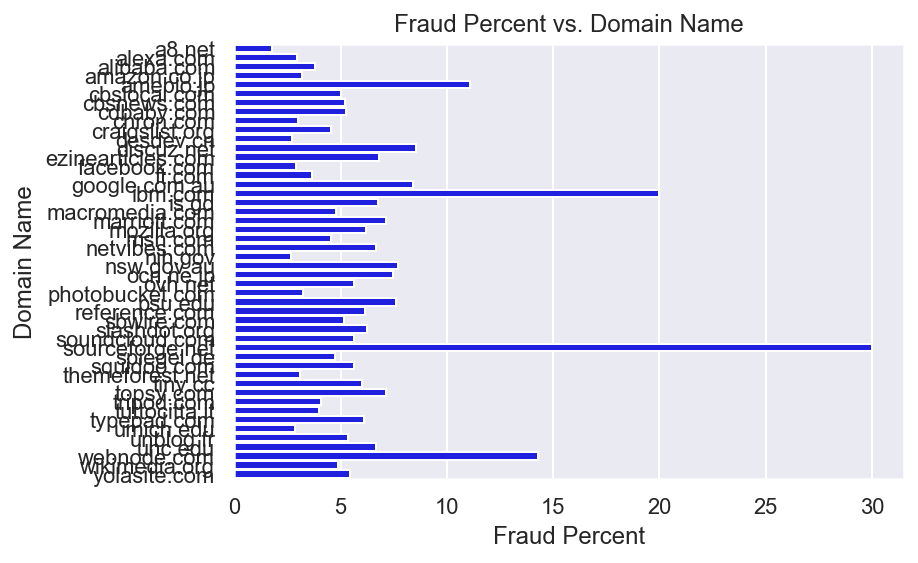

In [20]:
ax_barplot_domain = sns.barplot(x="fraud_percent", y="Domain_name",\
                            data=domain_fraud_pct,orient="h",ci=None,color="blue")
ax_barplot_domain.set_title("Fraud Percent vs. Domain Name")
ax_barplot_domain.set_xlabel("Fraud Percent")
ax_barplot_domain.set_ylabel("Domain Name")
plt.show()

In [22]:
domain_fraud_pct.sort_values('fraud_percent',axis=0,ascending=False).head(4)

,Domain_name,is_fraud,fraud_percent
82,sourceforge.net,1,30.000000
42,ibm.com,1,20.000000
110,webnode.com,1,14.285714
10,ameblo.jp,1,11.111111


Using the above barplot, it is immediately clear that few domains are highly notorious in terms of fraud percent. Therefore, it makes sense to include fraud percent for a given domain as a feature. But it is also possible that those allegedly bad domains might be rare, hence even 1 or 2 fraud cases might look like a lot. This will be investigated in later sections.

Next, we study the effect of number of visits to different sites, A,B, or C on the response variable. They are continuous variables, hence initially we will look at pairwise scatter plot grouped by the response variable,is_fraud.

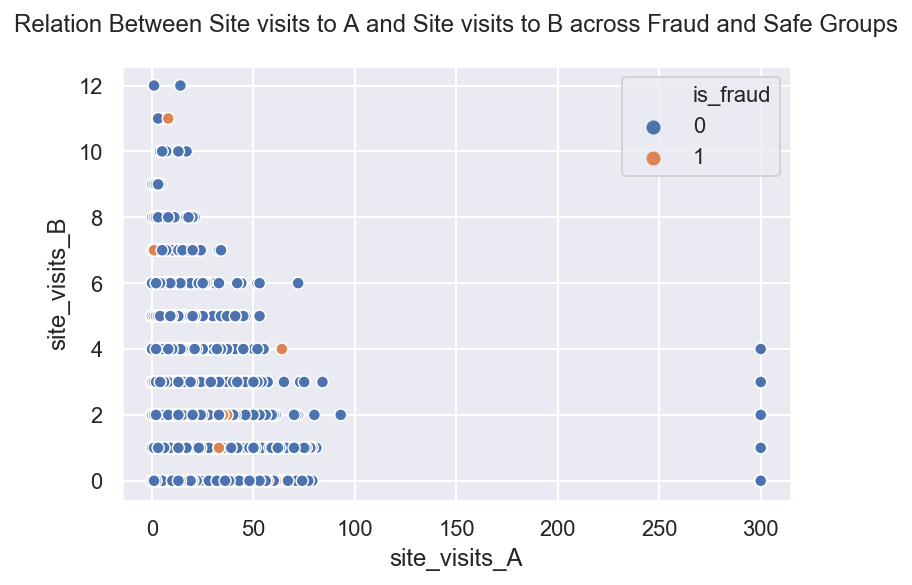

In [22]:
ax_site_A_B = sns.scatterplot(x='site_visits_A',y='site_visits_B',hue='is_fraud',data=fraud_data)

ax_site_A_B.set_title('Relation Between Site visits to A and Site visits to B across Fraud and Safe Groups',y=1.05)

plt.show()

We cannot see much linear behavior between number of visits to site A and number of visits to site B. To confirm, we can check the correlation matrix below.

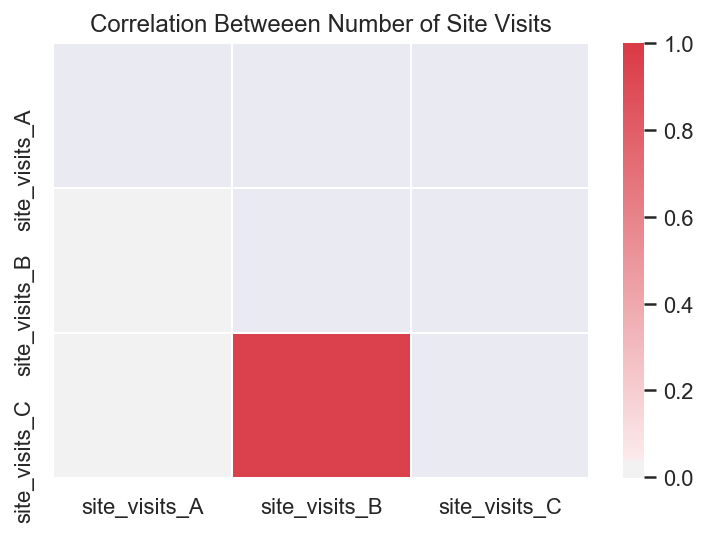

In [24]:
#filter the dataset to include above possible predictors.
site_visit_data=fraud_data[['site_visits_A','site_visits_B','site_visits_C']]
#compute the correlation matrix
corr=site_visit_data.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
cmap = sns.diverging_palette(220, 10, as_cmap=True)
axes_heat=sns.heatmap(corr, mask=mask, cmap=cmap, center=0,cbar=True,
             linewidths=.5,xticklabels=True,yticklabels=True, cbar_kws={"shrink": 1})
#sns.plt.suptitle('lalala')
axes_heat.set_title("Correlation Betweeen Number of Site Visits")
plt.show()

In [24]:
fraud_data[['site_visits_B','site_visits_C','site_visits_A']].corr()

,site_visits_B,site_visits_C,site_visits_A
site_visits_B,1.000000,0.954758,-0.002797
site_visits_C,0.954758,1.000000,0.001370
site_visits_A,-0.002797,0.001370,1.000000


In [15]:
fraud_data.drop(['site_visits_C'],axis=1,inplace=True)
fraud_data=fraud_data[fraud_data['site_visits_A']!='300']

Intrestingly, site visits to B and C are highly correlated. This tells us that duplicate informaton might be conveyed in both variables, i.e. multicollinearity. Hence, we can safely drop one of them. In particular, we drop the feature site_visits_C. Regarding, site_visits_A, and site_visits_B, we will keep them for now. Most likely, we will construct couple of new features using them in Feature Engineering section.

Now, we proceed to the last two numeric variables, Credit Limit, and Number of Transactions, and how they might affect the fraud decision. As per our understanding, this credit limit reflects the credit limit for the applicant on his/her previous credit card. Similarly for number of transactions. Since they are numeric in nature, we can quickly check its distribution using a histogram.

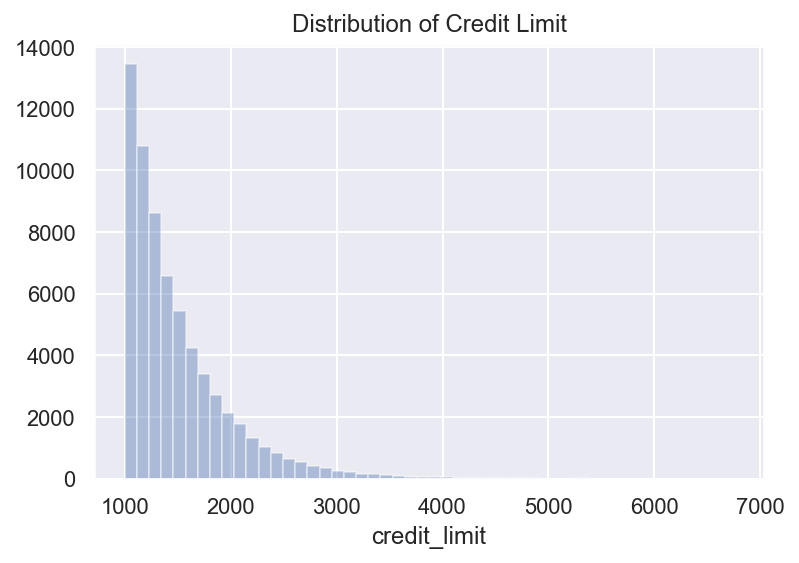

In [24]:
ax_credit=sns.distplot(fraud_data['credit_limit'],kde=False)
ax_credit.set_title("Distribution of Credit Limit")
plt.show()

In [33]:
fraud_data['credit_limit'].describe()

count    65469.000000
mean      1495.863215
std        494.311703
min       1000.010000
25%       1143.310000
50%       1342.580000
75%       1689.670000
max       6746.170000
Name: credit_limit, dtype: float64

As expected, the distribution is highly right skewed. Moreover, using the summary feature, we see that credit limit ranges from 1000 to almost 6000. This is not so much of a variation, so it is ok to use buckets of relatively small interval, say 300. This will be followed by a group by operation and aggregation function to compute the fraud percent in each bucket. 

In [22]:
fraud_data['group_credit']=pd.cut(fraud_data['credit_limit'],\
                                  range(1000,6800,300),right=False)
credit_fraud_pct= group_by_fraud_pct(fraud_data,'group_credit','is_fraud')

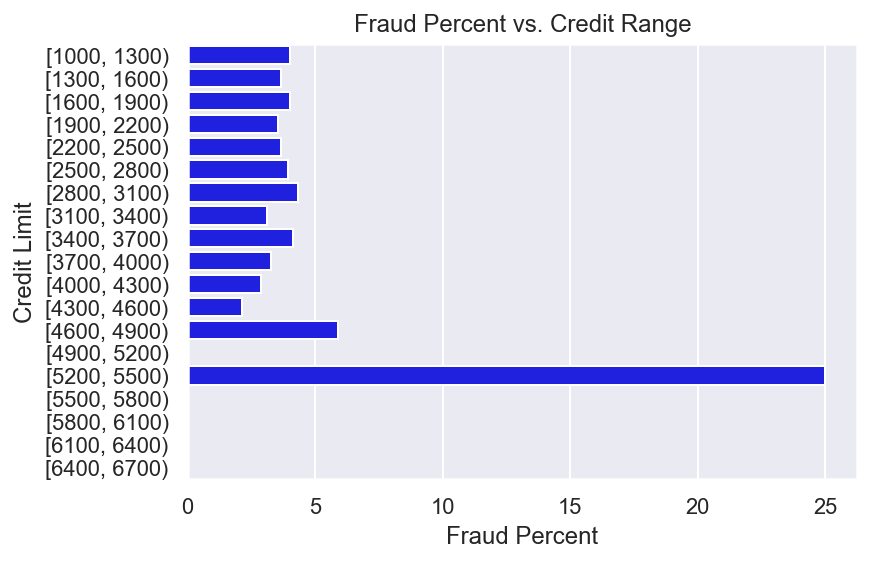

In [23]:
ax_barplot_credit = sns.barplot(x="fraud_percent", y="group_credit", \
                                data=credit_fraud_pct,orient="h",ci=None,color="blue")
ax_barplot_credit.set_title("Fraud Percent vs. Credit Range")
ax_barplot_credit.set_xlabel("Fraud Percent")
ax_barplot_credit.set_ylabel("Credit Limit")
plt.show()

We have some important information here. Interestingly, the applicants with higher credit limit (in the range 5200 to 5500), posess significant risk. Hence it seems to be a suitable predictor while predicting the phenomenon of fraud incidence. In the second attempt, we introduce fraud percent for given credit limit as a feature.
Next, we analyze the behavior of the feature, number of transactions. Its distribution is appoximately normal, as shown below.

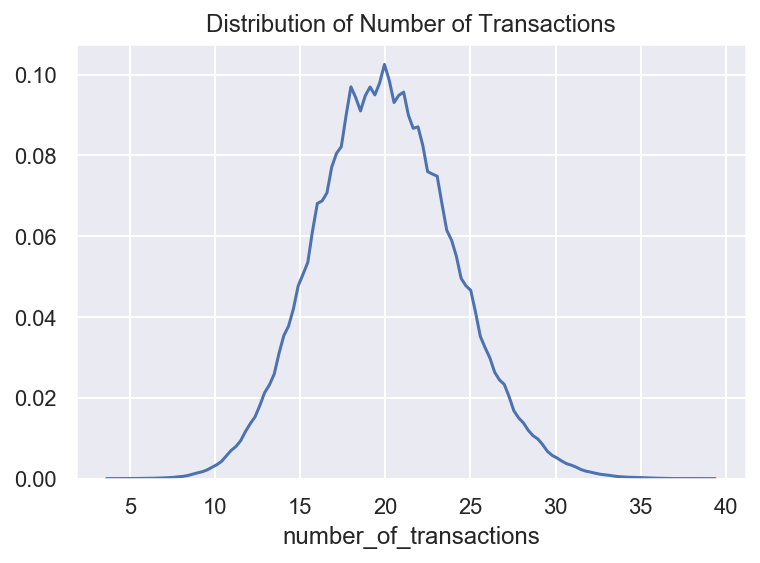

In [119]:
ax_transactions=sns.distplot(fraud_data['number_of_transactions'],hist=False,kde=True)
ax_transactions.set_title("Distribution of Number of Transactions")
plt.show()

In [43]:
fraud_data['number_of_transactions'].describe()

count    65469.000000
mean        20.006079
std          3.991605
min          5.000000
25%         17.000000
50%         20.000000
75%         23.000000
max         38.000000
Name: number_of_transactions, dtype: float64

The range is not showing much variation, therefore we can afford to make small bins here, in order to reduce information loss. Lets take bin size as 2 here.

In [24]:
fraud_data['group_transaction']=pd.cut(fraud_data['number_of_transactions'],\
                                       range(5,38,2),right=False)
transactions_fraud_pct= group_by_fraud_pct(fraud_data,'group_transaction','is_fraud')

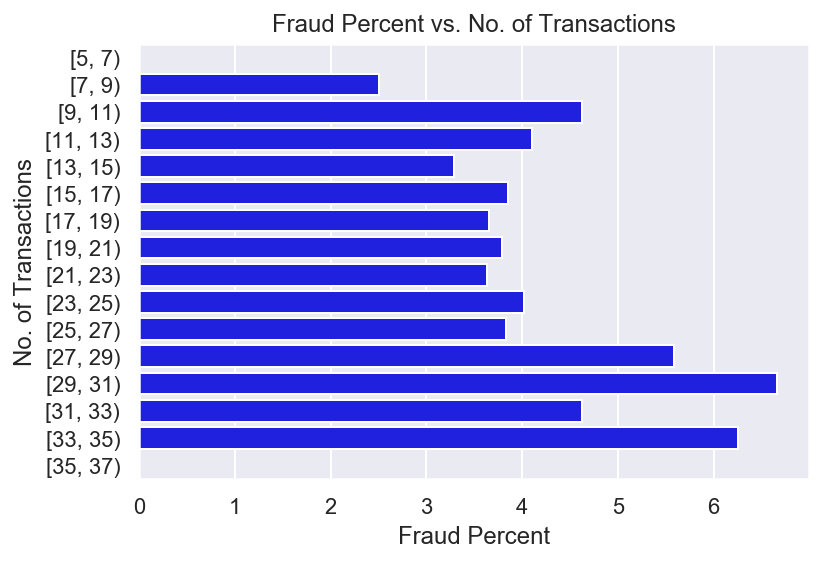

In [25]:
ax_barplot_transaction = sns.barplot(x="fraud_percent", y="group_transaction",\
                                     data=transactions_fraud_pct,orient="h",ci=None,color="blue")
ax_barplot_transaction.set_title("Fraud Percent vs. No. of Transactions")
ax_barplot_transaction.set_xlabel("Fraud Percent")
ax_barplot_transaction.set_ylabel("No. of Transactions")
plt.show()

As expected, the fraudsters tend to use the credit card a lot on a regular basis. This is obvious from above figure. But at the same time, we see that significant percent of fraudsters have also decided not to use the credit card a lot. This behavior is not so obvious. Business domain knowledge will be helpful at this stage.

In [26]:
fraud_data.dtypes

id                                             int64
dist_latest_transaction_address_km             int64
email                                         object
application_date                      datetime64[ns]
site_visits_A                                  int64
site_visits_B                                  int64
credit_limit                                 float64
number_of_transactions                         int64
is_fraud                                       int64
time                                           int64
day                                            int64
day_name                                      object
Domain_name                                   object
group_distance                              category
group_credit                                category
group_transaction                           category
dtype: object

Next, we try to look at some variable interactions.Do the fraudsters visit some sites more than others at a particular time of the day?

In [40]:
fraud_time_site_visits = fraud_data.groupby(['time', 'is_fraud'],as_index=False).agg({'site_visits_A':sum,'site_visits_B':sum})
fraud_time_site_visits.head(10)


,time,is_fraud,site_visits_A,site_visits_B
0,0,0,23699,2604
1,0,1,846,100
2,1,0,23426,2568
3,1,1,845,88
4,2,0,22898,2536
5,2,1,1009,110
6,3,0,23775,2585
7,3,1,816,100
8,4,0,23172,2379
9,4,1,974,102


In [32]:
fraud_time_site_visits['site_A_prop']=fraud_time_site_visits['site_visits_A']/(fraud_time_site_visits['site_visits_A']+fraud_time_site_visits['site_visits_B'])
fraud_time_site_visits['site_B_prop']=fraud_time_site_visits['site_visits_B']/(fraud_time_site_visits['site_visits_A']+fraud_time_site_visits['site_visits_B'])
fraud_time_site_visits['site_A_prop']=(fraud_time_site_visits['site_A_prop'])*100
fraud_time_site_visits['site_B_prop']=(fraud_time_site_visits['site_B_prop'])*100
fraud_time_site_visits.head(4)

,time,is_fraud,site_visits_A,site_visits_B,site_A_prop,site_B_prop
0,0,0,24299,2606,90.314068,9.685932
1,0,1,846,100,89.429175,10.570825
2,1,0,23426,2568,90.120797,9.879203
3,1,1,1145,89,92.787682,7.212318


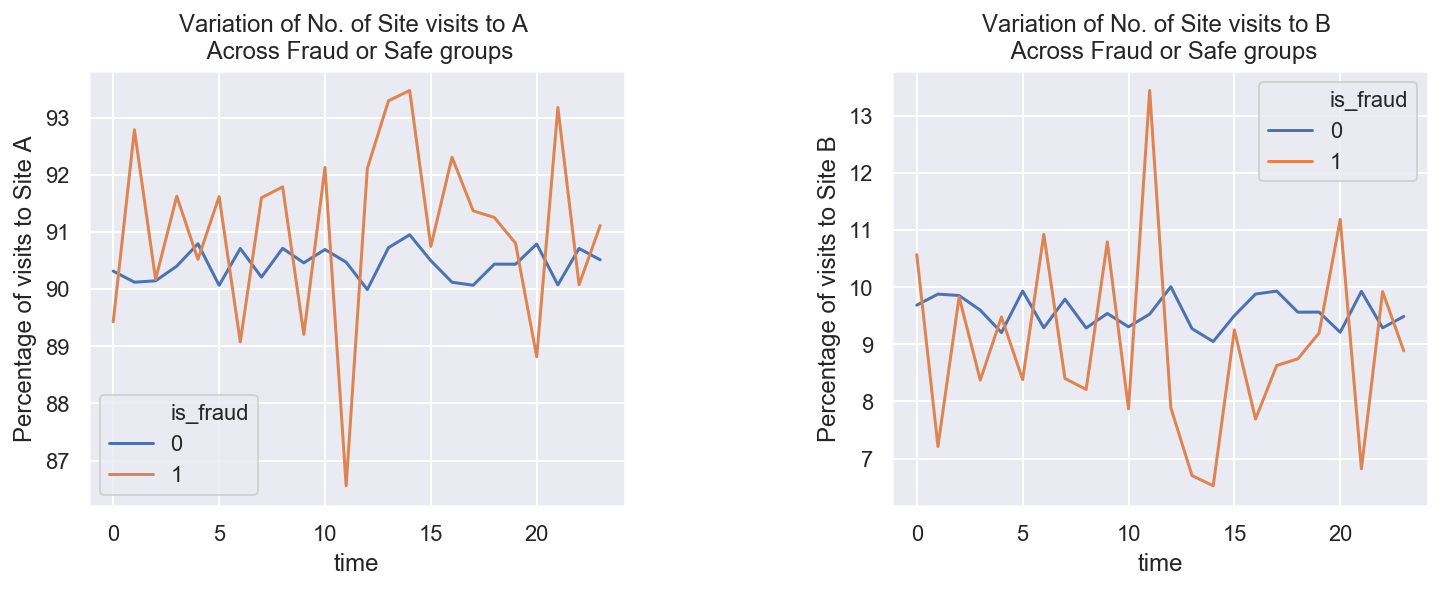

In [33]:
fig, ax =plt.subplots(1,2,figsize=(12,4))
sns.lineplot(x="time", y="site_A_prop", hue='is_fraud',data=fraud_time_site_visits,ax=ax[0])
ax[0].set_title("Variation of No. of Site visits to A \n Across Fraud or Safe groups",\
                       fontdict={'fontsize':12})

ax[0].set_ylabel("Percentage of visits to Site A")

sns.lineplot(x="time", y="site_B_prop", hue='is_fraud',data=fraud_time_site_visits,ax=ax[1])
ax[1].set_title("Variation of No. of Site visits to B \n Across Fraud or Safe groups",\
                        fontdict={'fontsize':12})

ax[1].set_ylabel("Percentage of visits to Site B")
fig.subplots_adjust(wspace=.5)
plt.show()

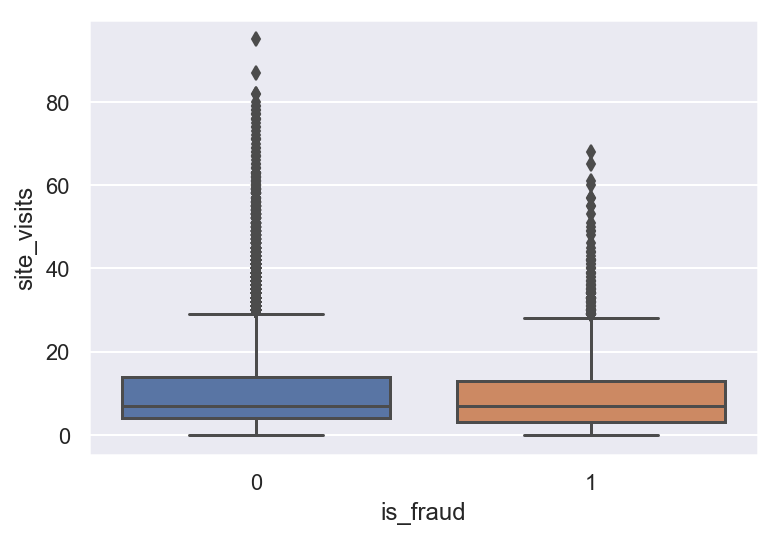

In [41]:
temp=fraud_data.copy()
temp['site_visits']=temp['site_visits_A']+temp['site_visits_B']
ax_site_visits=sns.boxplot(x='is_fraud',y='site_visits',data=temp)
plt.show()

Is it true that fraudsters tend to apply for new credit cards on particular days of the week? To this end, we will group data based on the variables, is_fraud and weekday.

In [ ]:
weekday_fraud_pct= group_by_fraud_pct(fraud_data,'day_name','is_fraud')
ax_fraud_day = sns.barplot(x="day_name", y="fraud_percent",ci=None,data=weekday_fraud_pct,color='blue')
ax_fraud_day.set_title("Variation of Fraud Percent With Respect to Day in the Week",\
                        fontdict={'fontsize':12})
ax_fraud_day.set_xlabel("Day of the Week")
ax_fraud_day.set_ylabel("Fraud Percent")
plt.show()

Along the same lines, is it true that fraudsters tend to apply for new credit cards on particular days of the month? To this end, we will group data based on the variables, is_fraud and day.

In [ ]:
day_fraud_pct= group_by_fraud_pct(fraud_data,'day','is_fraud')
ax_fraud_day = sns.lineplot(x="day", y="fraud_percent", data=day_fraud_pct)
ax_fraud_day.set_title("Variation of Fraud Percent With Respect to Day in the Month",\
                        fontdict={'fontsize':12})
ax_fraud_day.set_xlabel("Day of the Month")
ax_fraud_day.set_ylabel("Fraud Percent")
plt.show()

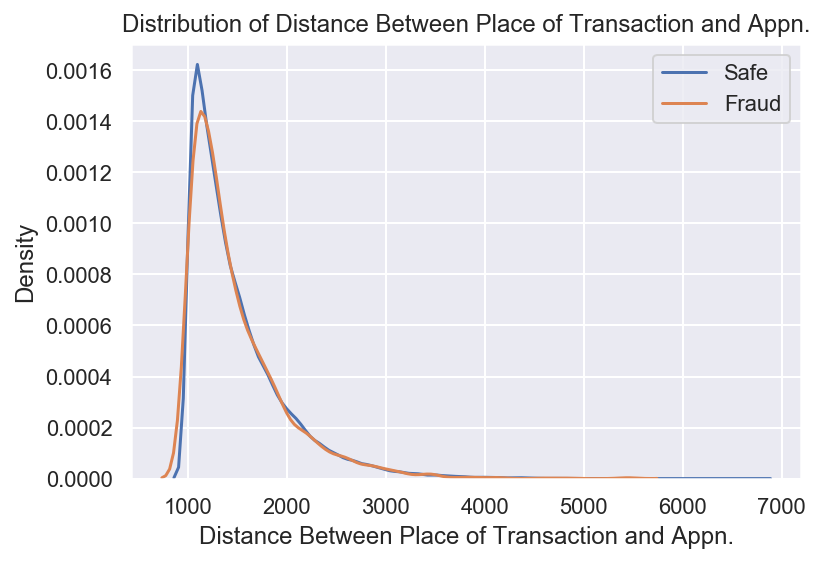

In [16]:
df = fraud_data[fraud_data['is_fraud'] == 0]
ax1=sns.distplot(df['credit_limit'], hist=False, kde = True, label='Safe')
df = fraud_data[fraud_data['is_fraud'] == 1]
ax1=sns.distplot(df['credit_limit'], hist=False, kde = True, label='Fraud')
# Plot formatting
#plt.legend(prop={'size': 12})
ax1.set_title('Distribution of Distance Between Place of Transaction and Appn.')
ax1.set_xlabel('Distance Between Place of Transaction and Appn.')
ax1.set_ylabel('Density')
plt.show()

From the above figure, we observe that the fraudsters have an erratic behavior while visiting the sites A or B, as compared to their non-fraud counterparts. Moreover, as observed before site A is more popular among both groups.
After performing the EDA, we plan to use following variables for our classification model,
* Number of transactions,
* Credit Limit,
* Distance Between the last transaction and Previous Credit Application, and
* Time.

## Modelling Process
Next, we begin with the modelling process. Here, different classification algorithms can be used, i.e. logistic regression, Decision trees etc. And keeping in mind the time constraints, we would prefer to go with trees, preferably Random forests. There are couple of reasons for this choice;

* Since Random forests is based on decision of majority, it is likely not to overfit and have low variance.
* Second, it selects an arbitray random sample of data to make each tree, it is highly likely that trees will be independent. Moreover, it select random subset of features as suitable candidates for splitting at a given node.
* Third, we have variables on different scale. Ideally, we should scale them so as to be in the similar range of values. This issue can be avoided in case of Random forests.

### Random Forests

#### Hyperparameter Tuning
One of the main features of Random Forests is selecting the optimal value of the hyperparameters. It has several hyperparameters that need to be tuned, such as number of Decision trees, Depth of the tree, Number of features used for splitting at each node in the tree, Minimum number of samples at a leaf so as to allow splitting etc. Cross validation is a suitable approach to select optimal values for these parameters. 
One possible approach is to define a list of values for each of the above hyperparameters and then use cross validation. But with so many hyperparameters, implementing cross-validation with each combination of values might be cumbersome. So we can start with tuning relatively more important hyperparameters, number of Decision trees, number of features selected for splitting at a tree node, and maximum depth of the tree.  

We can use either grid search or randomized search and implement cross validation for each combination of values. The main difference between these two search strategies is, grid search executes cross validation for each combination of values, whereas randomized search randomly selects combinations of values and performs validation for only those combinations. For the above problem, we propose to divide the dataset initially into two sets, trainig data and test data. It should be noted that test data will not be used for any type of tuning practice. It will be used in the very end to do the model predictions and compare the model's performance with the true labels.

First we define set of values for these hyperparameters, number of Decision trees, number of features selected for splitting at a tree node, and maximum depth of the tree.  It should be noted that, 'auto' means all the features are available for splitting, whereas 'sqrt' means that square root of the total number of features are available for splitting at node. 

In [47]:
n_estimators= [5,10,20,50,100]
max_features= ["auto","sqrt"]
max_depth=[4,6,8]
para_grid=product(n_estimators,max_features,max_depth)

In [30]:
fraud_data.columns

Index(['id', 'dist_latest_transaction_address_km', 'email', 'application_date',
       'site_visits_A', 'site_visits_B', 'credit_limit',
       'number_of_transactions', 'is_fraud', 'time', 'day', 'day_name',
       'Domain_name', 'group_distance', 'group_credit', 'group_transaction'],
      dtype='object')


### Baseline Model With Original Features
#### Train Test split
Next, we will perform the splitting into training and test set. To get consistent results, we can set the seed, random_state=0 

In [31]:
#fraud_data.replace({'is_fraud': {'No': 0,'Yes':1}},inplace=True)
rf_data=fraud_data.drop(['id','email','application_date','group_credit',\
                         'group_transaction','is_fraud','Domain_name','group_distance','day_name','day'],axis=1)
y=fraud_data['is_fraud'].copy()
rf_train,rf_test,y_train,y_test = train_test_split(rf_data,y,test_size=0.2,shuffle=True,stratify=y,random_state=0)

Next, we will split the training data into train set and validation set. We will try to keep 70 percent for training and 30 percent for validation. At the same time, we are using stratified sampling to make sure that distribution is consistent across the different sets. The main application of the validation set is to select the hyperparameters. 

In [33]:
rf_train_new,rf_valid,y_train_new,y_valid = train_test_split(rf_train,y_train,\
                                                             test_size=0.3,shuffle=True,stratify=y_train,random_state=0)

Now that data splitting has been done, here is the planned approach;
* Step 1: For a given value of the hyperparameter, following steps will be repeated;
 * train on the training set
 * Predict the class probabilities on the validation set
 * Assess the model performance on the validation set using a suitable metric
 * Go back to Step 1 and repeat.
* Choose the hyperparameters with best performance.

One important question to consider, which metric should be used. Since the data is skewed, accuracy won't be proper choice here. It will be useful to use the Area Under the ROC Curve(AUC) here, since it is independent of threshold as well as insenstive to class distribution. So higher the value of AUC, we expect the model to be better. One interpretation of AUC is that, given a pair of positive and negative example the area gives the probabiity that the model will provide more weightage to the positive example, in this case, fraud case. The area under the ROC curve should be greater than 0.5 (which is equivalent to random guess).  



In [48]:
def optimal_auc(data,para_grid,y_train_new,y_valid,rf_valid):
    best_score=0
    for param in para_grid:
        clf_rf = RandomForestClassifier(max_depth= param[2], max_features= param[1], n_estimators= param[0],\
                                            random_state=42).fit(data, y_train_new)
        probab=clf_rf.predict_proba(rf_valid)
        roc_auc=metrics.roc_auc_score(np.array(y_valid),np.array(probab[:,1]))
        if roc_auc>best_score:
            best_score=roc_auc
            best_param=param
    return best_score,best_param

#### Threshold Selection

Using this approach, we obtain best AUC of 0.57555 with following values of parameters; 

* no. of trees: 10
* feature selection method: auto
* maximum depth allowed : 6

Next we will use these settings to train the training set once more and perform predictions on validation set. The goal is to select proper threshold. This threshold will be used to perform the predictions on the hold out set, i.e. test set. It is well known that the default threshold provided by sickit learn is 0.5, which is rarely useful for practical cases. Selection of threshold is more of a business problem rather than technical issue. For example, in case of fraud, we should be okay with few more false positives, rather than failing to catch the fraud cases (i.e. false negtaive).

We will plot a histogram of predicted probabilities on the validation set, and use that togther with a user defined function to identify the optimal threhold. Just for illustration, we will also plot the ROC curve on the validation set.

In [35]:
answer=optimal_auc(rf_train_new,para_grid,y_train_new,y_valid,rf_valid)

In [37]:
clf_new = RandomForestClassifier(max_depth= answer[1][2], max_features= answer[1][1], n_estimators= answer[1][0],\
                                            random_state=42).fit(rf_train_new, y_train_new)probab_new=clf_new.predict_proba(rf_valid)

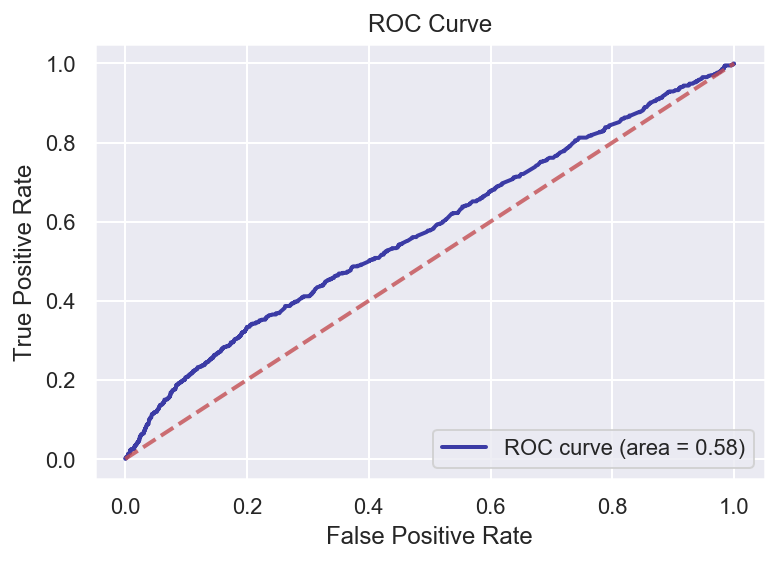

In [38]:
fpr, tpr, thresholds = metrics.roc_curve(np.array(y_valid),np.array(probab_new[:,1]),1)
plt.plot(fpr, tpr, lw=2, alpha=0.75, color='darkblue',label='ROC curve (area = %0.2f)' % answer[0])
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', alpha=.8)
plt.legend(loc="lower right")
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.title("ROC Curve")
plt.show()

Our model is a bit better than random guessing. We will talk more about its improvement in Discussion and Conclusion section. Here, we will discuss the ROC curve and its characteristics. Every point on the ROC curve corresponds to a given threshold value, false psitive rate, and true positive rate for that threshold. On the top right corner, the threshold value is quite low, and on bottom left, the threshold is close to 1, hence both true positive rate as well as false positve rate are close to 0.

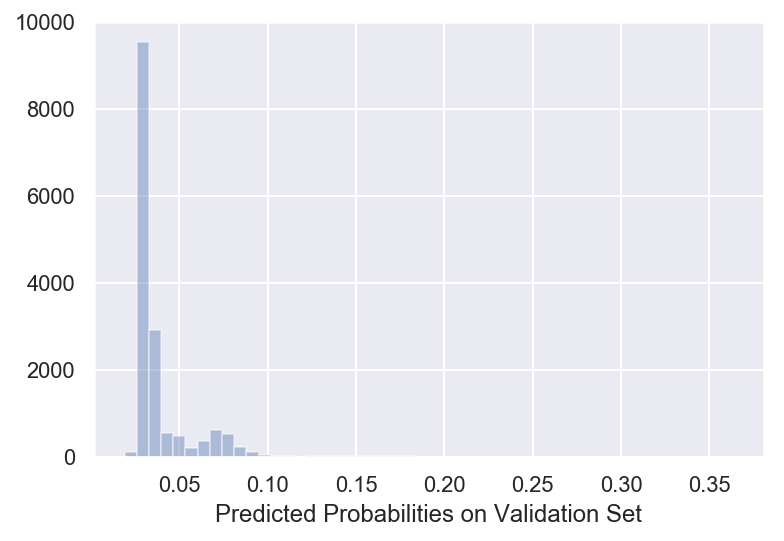

In [46]:
ax_probs=sns.distplot(probab_new[:,1],kde=False)
ax_probs.set_xlabel("Predicted Probabilities on Validation Set")
plt.show()

In [47]:
temp=probab_new[:,1].copy()


In [99]:
# define a function that accepts a threshold and prints sensitivity and specificity(1-fpr)
def evaluate_threshold(threshold):
    print('Sensitivity:', tpr[thresholds > threshold][-1])
    print('Specificity:', 1 - fpr[thresholds > threshold][-1])

In [94]:
probab_new[:,1]

array([0.03381972, 0.03109869, 0.07576758, ..., 0.06608093, 0.03109869,
       0.0299884 ])

In [96]:
temp

array([0.03381972, 0.03109869, 0.07576758, ..., 0.06608093, 0.03109869,
       0.0299884 ])

In [48]:
temp[temp>=0.03]=1
temp[temp<0.03]=0
print classification_report(y_valid,temp)

              precision    recall  f1-score   support

           0       0.97      0.20      0.34     15105
           1       0.04      0.84      0.08       608

   micro avg       0.23      0.23      0.23     15713
   macro avg       0.51      0.52      0.21     15713
weighted avg       0.93      0.23      0.33     15713



After observing the graph and above function,0.03 seems to be  suitable choice for threshold on the test set. It should be note that threshold has been selected based on the performance on validation set. 

In [49]:
#Predictions on the Test Set
clf_final = RandomForestClassifier(max_depth= 6, max_features= 'auto', n_estimators= 10,\
                                            random_state=42).fit(rf_train, y_train)
probab_test=clf_final.predict_proba(rf_test)
probab_test[:,1][probab_test[:,1]>=0.03]=1
probab_test[:,1][probab_test[:,1]<0.03]=0
print classification_report(y_test,probab_test[:,1])

              precision    recall  f1-score   support

           0       0.97      0.13      0.23     12587
           1       0.04      0.89      0.08       507

   micro avg       0.16      0.16      0.16     13094
   macro avg       0.50      0.51      0.15     13094
weighted avg       0.93      0.16      0.23     13094



#### Discussion
Above, we manged to get a decent Recall (i.e. ability to catch the fraud cases) of 0.87. But the precision is quite low. It means we might end up with false positives. This is a typical problem in classification problems, and a lot depnds on the choice of threshold. At the same time, depending on the problem at hand one metric can be given more weightage than the other. For example, in cases related to fraud identification, it is acceptable to identify some false positives, but we should not let the fraud applications go through. 
In order to improve the precision without sacrificing the recall, it is worthwhile trying a better model. Another approach can be to deploy some new features, i.e. feature engineering. For example, more business related information for the features related to site visits can be used to develop new features.


### Feature Engineering With Random Forests: Approach 1
Using the site visits to A and B, can we define new features and retrieve more information. One possible way is to find the percentage of visits to either of the sites.Before going towards designing new features, it might also help to take care of few outliers.
 




In [50]:

fraud_data['visit_A_prop']=fraud_data['site_visits_A']/(fraud_data['site_visits_A']+fraud_data['site_visits_B'])
fraud_data['visit_B_prop']=fraud_data['site_visits_B']/(fraud_data['site_visits_A']+fraud_data['site_visits_B'])

It seems site A is much more popular as compared to site B. Is the same true for fraud cases? To this end, we can bucket these columns and compute the fraud percentage as above.

In [51]:
fraud_data['visit_A_prop_group']= pd.cut(fraud_data['visit_A_prop'],bins=10,include_lowest=True)

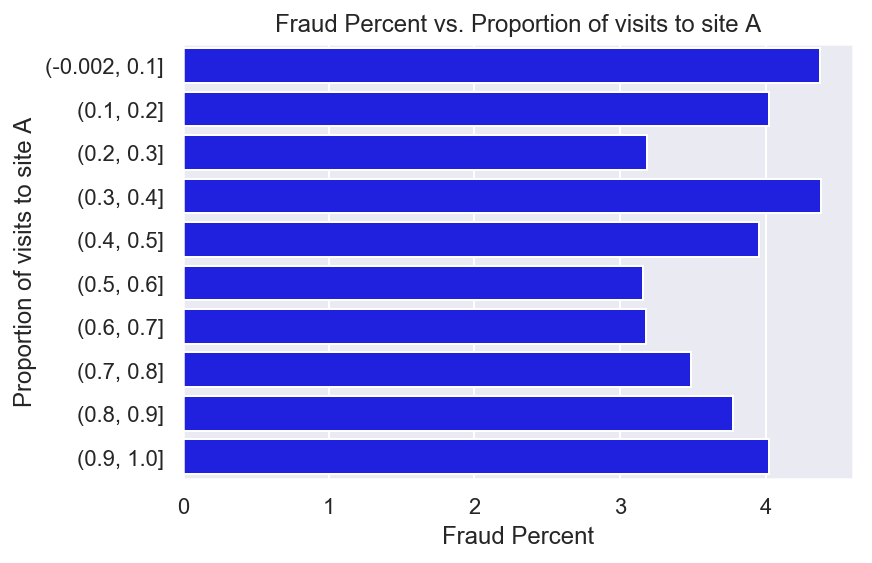

In [52]:
siteA_prop_fraud_pct= group_by_fraud_pct(fraud_data,'visit_A_prop_group','is_fraud')
ax_barplot_prop_site_A = sns.barplot(x="fraud_percent", y="visit_A_prop_group", data=siteA_prop_fraud_pct,orient="h",ci=None,color="blue")
ax_barplot_prop_site_A.set_title("Fraud Percent vs. Proportion of visits to site A")
ax_barplot_prop_site_A.set_xlabel("Fraud Percent")
ax_barplot_prop_site_A.set_ylabel("Proportion of visits to site A")
plt.show()

In [53]:
fraud_data['visit_B_prop_group']= pd.cut(fraud_data['visit_B_prop'],bins=10,include_lowest=True)


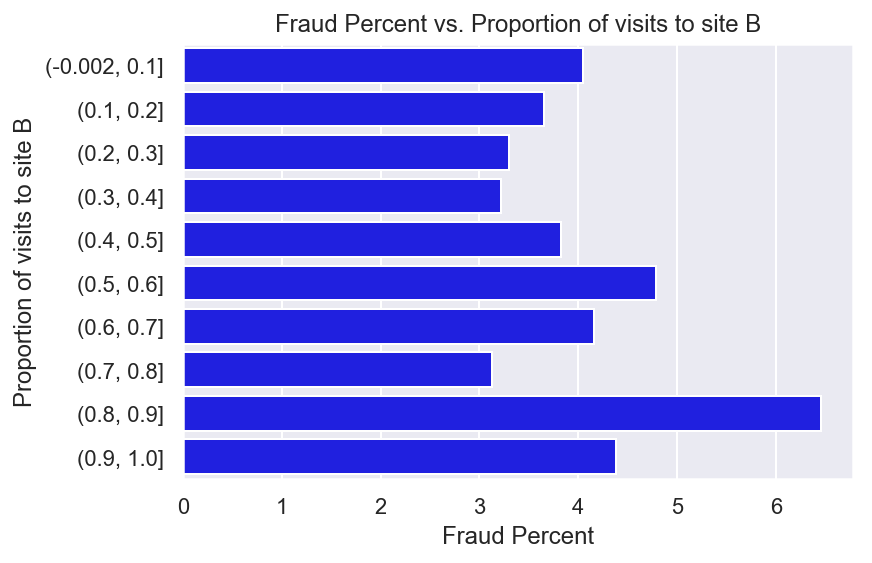

In [54]:
siteB_prop_fraud_pct= group_by_fraud_pct(fraud_data,'visit_B_prop_group','is_fraud')
ax_barplot_prop_site_B = sns.barplot(x="fraud_percent", y="visit_B_prop_group", data=siteB_prop_fraud_pct,orient="h",ci=None,color="blue")
ax_barplot_prop_site_B.set_title("Fraud Percent vs. Proportion of visits to site B")
ax_barplot_prop_site_B.set_xlabel("Fraud Percent")
ax_barplot_prop_site_B.set_ylabel("Proportion of visits to site B")
plt.show()

Looking at the above bar charts, we don't see a clear trend between fraud percent and proportion of visits to a particular site. The behavior is quite oscillatory, hence at this stage, we don't intend to use these two variables in our classification model.  

We will define a new feature, related to the time column. We see that the fraud percentage is high from 3 p.m to almost 7 p.m. Therefore, we plan to define a new variable, fraud_pct_time_window, which will have three values;

* High, for time between 3p.m and 7p.m
* Low, for time between 11 a.m and 3p.m, and 
* Medium for other time instants. 

In [55]:
def define_fraud_time(time):
    #print domain
    if time in range(15,20):
     #   print 'rare'
        return 'High'
    elif time in range(11,16):
        return 'Low'
    else:
        return 'Medium'

In [56]:
fraud_data['fraud_pct_time_window']=fraud_data['time'].apply(define_fraud_time)

Next, we define a new feature, that helps to identify the fraud existence, depending on the bracket in which the credit limit belongs to. We saw in the EDA section that, fraud percent is high for higher credit limits, in the range 4500 to 5500. A new feature, called fraud_pct_credit_window will be defined having just two values;
* High, if the credit limit is in the range (4500,5500),
* Low, otherwise.

In [57]:
def define_fraud_credit(credit):
    #print domain
    if credit >4500 and credit<=5500:
     #   print 'rare'
        return 'High'
    else:
        return 'Low'

In [58]:
fraud_data['fraud_pct_credit_window']=fraud_data['credit_limit'].apply(define_fraud_credit)

Similarly, we try to correlate fraud percentage with number of transactions. We saw that for very small as well as large number of transactions, the fraud behavior is more prevalent. Therefore we define a new variable, called fraud_percent_transactions_window, which will have only two values;
* Low if number of transactions between 8 and 26, and
* High otherwise.

In [59]:
fraud_data['fraud_percent_transactions_window']=fraud_data['number_of_transactions'].apply(lambda x: 'Low' if x > 8 and x <= 26 
                                                                                           else 'High')

In [60]:
fraud_data[fraud_data['fraud_percent_transactions_window'] =='High'].head(4)

,id,dist_latest_transaction_address_km,email,application_date,site_visits_A,site_visits_B,credit_limit,number_of_transactions,is_fraud,time,day,day_name,Domain_name,group_distance,group_credit,group_transaction,visit_A_prop,visit_B_prop,visit_A_prop_group,visit_B_prop_group,fraud_pct_time_window,fraud_pct_credit_window,fraud_percent_transactions_window
30,30,6,jmeddingsfk@themeforest.net,2019-04-05 00:15:26.447936,9,2,3580.71,27,0,0,5,Fri,themeforest.net,"(4.0, 6.0]","[3400, 3700)","[27, 29)",0.818182,0.181818,"(0.8, 0.9]","(0.1, 0.2]",Medium,Low,High
45,45,10,dnorval2k@unblog.fr,2019-03-19 23:28:49.765538,31,1,1617.02,27,0,23,19,Tue,unblog.fr,"(8.0, 10.0]","[1600, 1900)","[27, 29)",0.968750,0.031250,"(0.9, 1.0]","(-0.002, 0.1]",Medium,Low,High
50,50,2,sthomasongh@amazon.co.jp,2019-04-02 12:25:57.189933,0,4,1683.01,30,0,12,2,Tue,amazon.co.jp,"(-0.001, 2.0]","[1600, 1900)","[29, 31)",0.000000,1.000000,"(-0.002, 0.1]","(0.9, 1.0]",Low,Low,High
72,72,11,bchomiszewski70@desdev.cn,2019-03-08 01:42:51.396498,1,1,1487.79,28,0,1,8,Fri,desdev.cn,"(10.0, 12.0]","[1300, 1600)","[27, 29)",0.500000,0.500000,"(0.4, 0.5]","(0.4, 0.5]",Medium,Low,High


Next, we define a new feature related to fraud behavior depending on distance between place of transaction and application. We saw above that for distances in the range (12,32) and (40,44) the fraud percentage was high.

In [61]:
def define_fraud_distance(distance):
    #print domain
    if 12 < distance <= 32 or 40 < distance <= 44:
     #   print 'rare'
        return 'High'
    else:
        return 'Low'

In [62]:
fraud_data['fraud_pct_distance_window']=fraud_data['dist_latest_transaction_address_km'].apply(define_fraud_distance)

In [63]:
fraud_data.head(4)

,id,dist_latest_transaction_address_km,email,application_date,site_visits_A,site_visits_B,credit_limit,number_of_transactions,is_fraud,time,day,day_name,Domain_name,group_distance,group_credit,group_transaction,visit_A_prop,visit_B_prop,visit_A_prop_group,visit_B_prop_group,fraud_pct_time_window,fraud_pct_credit_window,fraud_percent_transactions_window,fraud_pct_distance_window
0,0,11,lmeechan7i@cbsnews.com,2019-04-23 07:56:50.487770,6,0,1941.32,22,0,7,23,Tue,cbsnews.com,"(10.0, 12.0]","[1900, 2200)","[21, 23)",1.00000,0.00000,"(0.9, 1.0]","(-0.002, 0.1]",Medium,Low,Low,Low
1,1,1,nwarkupic@desdev.cn,2019-03-11 17:27:51.857759,36,0,1149.98,17,0,17,11,Mon,desdev.cn,"(-0.001, 2.0]","[1000, 1300)","[17, 19)",1.00000,0.00000,"(0.9, 1.0]","(-0.002, 0.1]",High,Low,Low,Low
2,2,1,dcoolpg@yolasite.com,2019-04-30 00:40:09.281798,3,1,1613.38,14,0,0,30,Tue,yolasite.com,"(-0.001, 2.0]","[1600, 1900)","[13, 15)",0.75000,0.25000,"(0.7, 0.8]","(0.2, 0.3]",Medium,Low,Low,Low
3,3,0,dreddington96@tiny.cc,2019-03-17 22:38:56.243197,31,1,1166.62,26,0,22,17,Sun,tiny.cc,"(-0.001, 2.0]","[1000, 1300)","[25, 27)",0.96875,0.03125,"(0.9, 1.0]","(-0.002, 0.1]",Medium,Low,Low,Low


Now that we have most of the features engineered, we can drop some of the original features to avoid effects of multicollinearity.

In [64]:
fraud_data.columns

Index([u'id', u'dist_latest_transaction_address_km', u'email',
       u'application_date', u'site_visits_A', u'site_visits_B',
       u'credit_limit', u'number_of_transactions', u'is_fraud', u'time',
       u'day', u'day_name', u'Domain_name', u'group_distance', u'group_credit',
       u'group_transaction', u'visit_A_prop', u'visit_B_prop',
       u'visit_A_prop_group', u'visit_B_prop_group', u'fraud_pct_time_window',
       u'fraud_pct_credit_window', u'fraud_percent_transactions_window',
       u'fraud_pct_distance_window'],
      dtype='object')

In [65]:
fraud_data_new=fraud_data.drop(['id','dist_latest_transaction_address_km','email','application_date','credit_limit','number_of_transactions',\
                 'Domain_name','is_fraud','day','day_name','visit_A_prop','visit_B_prop','visit_A_prop_group','visit_B_prop_group','group_distance','group_credit','group_transaction'],axis=1)

In [66]:
fraud_data_new.columns

Index([u'site_visits_A', u'site_visits_B', u'time', u'fraud_pct_time_window',
       u'fraud_pct_credit_window', u'fraud_percent_transactions_window',
       u'fraud_pct_distance_window'],
      dtype='object')

Using scatter plots, we can't observe much relation between time and number of site visits across the fraud as well as safe population. We can conclude absence of interaction between these two variables. Now we have categorical variables in the data, so it makes sense to use some sort of one hot encoding to binarize these variables. 

In [68]:
X=fraud_data_new.copy()
y=fraud_data['is_fraud'].copy()

In [69]:
X_binary=pd.get_dummies(X,drop_first=True)
rf_train,rf_test,y_train,y_test = train_test_split(X_binary,y,test_size=0.2,shuffle=True,stratify=y,random_state=0)


In [70]:
X_binary.head(2)

,site_visits_A,site_visits_B,time,fraud_pct_time_window_Low,fraud_pct_time_window_Medium,fraud_pct_credit_window_Low,fraud_percent_transactions_window_Low,fraud_pct_distance_window_Low
0,6,0,7,0,1,1,1,1
1,36,0,17,0,0,1,1,1


In [71]:
rf_train_new,rf_valid,y_train_new,y_valid = train_test_split(rf_train,y_train,\
                                                             test_size=0.3,shuffle=True,stratify=y_train,random_state=0)

Next, we call the function to compute the optimal auc using the validation set as before.

In [74]:
optimal_auc(rf_train_new,para_grid,y_train_new,y_valid,rf_valid)

(0.553576652195455, (20, 'auto', 4))

We do not see any improvement in the AUC. On the other hand, AUC decreased. In this model, we haven't included any information regarding the domain name. Next, we propose to add fraud percentage for a given domain, credit limit as well as Distance between Application address and place of transaction as 3 features.

In [42]:
fraud_data.columns

Index(['id', 'dist_latest_transaction_address_km', 'email', 'application_date',
       'site_visits_A', 'site_visits_B', 'credit_limit',
       'number_of_transactions', 'is_fraud', 'time', 'day', 'day_name',
       'Domain_name', 'group_distance', 'group_credit', 'group_transaction'],
      dtype='object')

### Feature Engineering With Random Forests: Approach 2
Here, we will add fraud percent corresponding to following attributes; Domain name,Distance between place of transaction and Place of Application, and Credit limit. In the earlier barcharts,  we saw clear trend in fraud percentage across different values for these variables.  

In [43]:
df_new=fraud_data.drop(['id','dist_latest_transaction_address_km', 'email', 'application_date',
        'credit_limit', 'number_of_transactions', 'time',
       'day', 'day_name'],axis=1).copy()
df_new.columns

Index(['site_visits_A', 'site_visits_B', 'is_fraud', 'Domain_name',
       'group_distance', 'group_credit', 'group_transaction'],
      dtype='object')

In [45]:
df_new = pd.merge(left=df_new, right=domain_fraud_pct,how='left', left_on='Domain_name',
                right_on='Domain_name')
df_new.drop(['is_fraud_y'],axis=1,inplace=True)
df_new.rename(columns={'is_fraud_x':'is_fraud','fraud_percent':'fraud_percent_domain'},inplace=True)
df_new.columns

Index(['site_visits_A', 'site_visits_B', 'is_fraud', 'Domain_name',
       'group_distance', 'group_credit', 'group_transaction',
       'fraud_percent_domain'],
      dtype='object')

In [46]:
df_new = pd.merge(left=df_new, right=distance_fraud_pct,how='left', left_on='group_distance',
                right_on='group_distance')
df_new.drop(['is_fraud_y'],axis=1,inplace=True)
df_new.rename(columns={'is_fraud_x':'is_fraud','fraud_percent':'fraud_percent_distance'},inplace=True)
df_new.columns

Index(['site_visits_A', 'site_visits_B', 'is_fraud', 'Domain_name',
       'group_distance', 'group_credit', 'group_transaction',
       'fraud_percent_domain', 'fraud_percent_distance'],
      dtype='object')

In [47]:
df_new = pd.merge(left=df_new, right=credit_fraud_pct,how='left', left_on='group_credit',
                right_on='group_credit')
df_new.drop(['is_fraud_y'],axis=1,inplace=True)
df_new.rename(columns={'is_fraud_x':'is_fraud','fraud_percent':'fraud_percent_credit'},inplace=True)
df_new.columns

Index(['site_visits_A', 'site_visits_B', 'is_fraud', 'Domain_name',
       'group_distance', 'group_credit', 'group_transaction',
       'fraud_percent_domain', 'fraud_percent_distance',
       'fraud_percent_credit'],
      dtype='object')

In [48]:
df_new = pd.merge(left=df_new, right=transactions_fraud_pct,how='left', left_on='group_transaction',
                right_on='group_transaction')
df_new.drop(['is_fraud_y'],axis=1,inplace=True)
df_new.rename(columns={'is_fraud_x':'is_fraud','fraud_percent':'fraud_percent_transaction'},inplace=True)
df_new.columns

Index(['site_visits_A', 'site_visits_B', 'is_fraud', 'Domain_name',
       'group_distance', 'group_credit', 'group_transaction',
       'fraud_percent_domain', 'fraud_percent_distance',
       'fraud_percent_credit', 'fraud_percent_transaction'],
      dtype='object')

In [49]:
df_new['fraud_percent_credit']= df_new['fraud_percent_credit'].fillna(0)
df_new['fraud_percent_domain']= df_new['fraud_percent_domain'].fillna(0)
df_new['fraud_percent_distance']= df_new['fraud_percent_distance'].fillna(0)
df_new['fraud_percent_transaction']= df_new['fraud_percent_transaction'].fillna(0)

In [50]:
df_new.drop(['Domain_name','group_distance','group_credit','group_transaction'],axis=1,inplace=True)

In [51]:
X=df_new.drop(['is_fraud'],axis=1)
y=df_new['is_fraud'].copy()

In [52]:
X.columns

Index(['site_visits_A', 'site_visits_B', 'fraud_percent_domain',
       'fraud_percent_distance', 'fraud_percent_credit',
       'fraud_percent_transaction'],
      dtype='object')

In [53]:
rf_train,rf_test,y_train,y_test = train_test_split(X,y,test_size=0.2,shuffle=True,stratify=y,random_state=0)
rf_train_new,rf_valid,y_train_new,y_valid = train_test_split(rf_train,y_train,\
                                                             test_size=0.3,shuffle=True,stratify=y_train,random_state=0)

In [56]:
ans=optimal_auc(rf_train_new,para_grid,y_train_new,y_valid,rf_valid)

In [57]:
ans

(0.6464678718270354, (5, 'auto', 4))

In [58]:
clf_improved = RandomForestClassifier(max_depth= 6, max_features= 'auto', n_estimators= 5,\
                                            random_state=42).fit(rf_train_new, y_train_new)
probab_new=clf_improved.predict_proba(rf_valid)

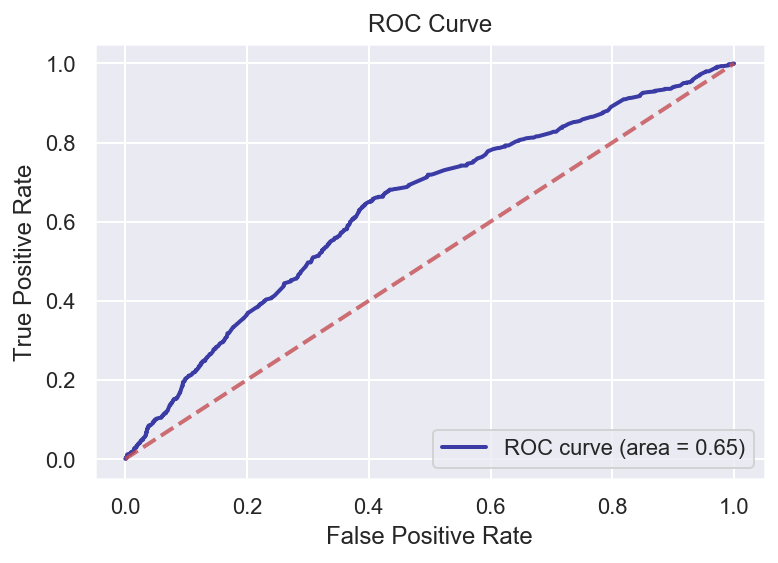

In [59]:
fpr, tpr, thresholds = metrics.roc_curve(np.array(y_valid),np.array(probab_new[:,1]),1)
plt.plot(fpr, tpr, lw=2, alpha=0.75, color='darkblue',label='ROC curve (area = %0.2f)' % ans[0])
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', alpha=.8)
plt.legend(loc="lower right")
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.title("ROC Curve")
plt.show()

### Discussion
Here, we have an improvement of AUC as compared to earlier models. That is a good news. It seems adding fraud percent corresponding to domain names,credit limit, and distanc between credit application and place of transaction.  do contain valuable information regarding fraud data. Earlier we saw that few domains have considerably higher fraud percent as compared to other counterparts. That can be possible reason for the improvment of AUC by adding this new feature, fraud percent for given domain.

### Performance Summary


| Algorithm | Features Used  | AUC On Validation Set|
|-----------|----------------|----------------------|
|   Random Forests  | Original Features Used|0.58|
|Random Forests     | Added Fraud Percent for Domain, Credit limit, and Distance | 0.64|






####  Performing Empirical Bayes Estimation
Earlier, we saw that incorporating fraud percent for varous domains, range of distance between place of transaction and number of transactions helped to obtain more discriminative model. While calculating the fraud percentage, we did not take into account the fact that few values are very rare. Next, we plan to use the idea of Empirical Bayes Estimation to update the fraud percentage taking into consideration the frequencies of particular values for that variable. 
As a test, we wil begin with the variable, domain name.

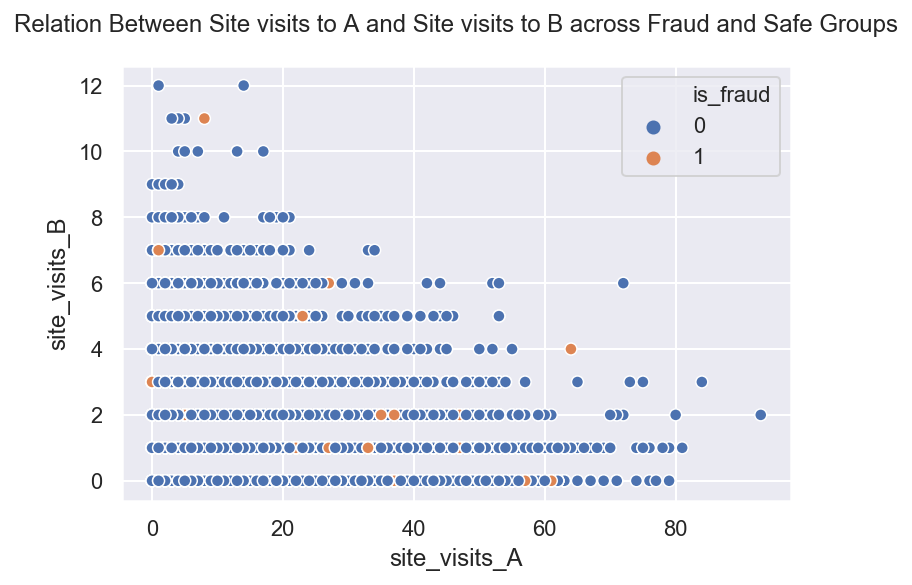

In [26]:
ax_site_A_B = sns.scatterplot(x='site_visits_A',y='site_visits_B',hue='is_fraud',data=fraud_data)

ax_site_A_B.set_title('Relation Between Site visits to A and Site visits to B across Fraud and Safe Groups',y=1.05)

plt.show()

In [60]:
fraud_data.columns

Index(['id', 'dist_latest_transaction_address_km', 'email', 'application_date',
       'site_visits_A', 'site_visits_B', 'credit_limit',
       'number_of_transactions', 'is_fraud', 'time', 'day', 'day_name',
       'Domain_name', 'group_distance', 'group_credit', 'group_transaction'],
      dtype='object')

In [17]:
#counts=fraud_data['Domain_name'].value_counts()
#counts[counts>10]
fraud_data_2=fraud_data.copy()
#fraud_data_2=fraud_data_2[fraud_data_2['Domain_name'].isin(counts[counts > 10].index)]
#fraud_data_2=fraud_data_2[fraud_data_2['credit_limit'] <= 5000]

In [62]:
fraud_data_2['is_fraud'].value_counts(normalize=True)

0    0.961295
1    0.038705
Name: is_fraud, dtype: float64

In [18]:
domain_fraud=fraud_data_2.groupby(['Domain_name','is_fraud']).agg({'id':'count'})
#domain_fraud_pct=gb_fraud.groupby('Domain_name').apply(lambda x: (x / float(x.sum())))
#pcts = domain_fraud_pct.reset_index()

In [19]:
domain_fraud_wide=domain_fraud.unstack()
domain_fraud_wide.columns=domain_fraud_wide.columns.droplevel(0)
domain_fraud_wide.head(2)

is_fraud,0,1
Domain_name,,
360.cn,10.0,NaN
a8.net,56.0,1.0


In [20]:
domain_fraud_wide['domain_count']=domain_fraud_wide[0]+domain_fraud_wide[1]

In [21]:
domain_fraud_wide['fraud_prop']=domain_fraud_wide[1]/domain_fraud_wide['domain_count']
domain_fraud_wide.rename(columns={0:'safe',1:'fraud'},inplace=True)
domain_fraud_wide.head(2)

is_fraud,safe,fraud,domain_count,fraud_prop
Domain_name,,,,
360.cn,10.0,NaN,NaN,NaN
a8.net,56.0,1.0,57.0,0.017544


In [22]:
domain_fraud_wide=domain_fraud_wide.reset_index()

In [23]:
domain_fraud_wide.columns.name=None

In [24]:
domain_fraud_wide['modified_fraud_domain_prop']=(19+domain_fraud_wide['fraud'])/(19+481+domain_fraud_wide['domain_count'])

The expected value for this fraud percentage is 0.66, which is way different from the overall fraud percent of 0.038. One way to figure out alpha and beta is to solve $\alpha$/($\alpha$+$\beta$)=$0.038$. This gives us, $\alpha=19$ and $\beta=481$. To illustrate we see that expected value for these values of $\alpha$ and $\beta$ is given below.


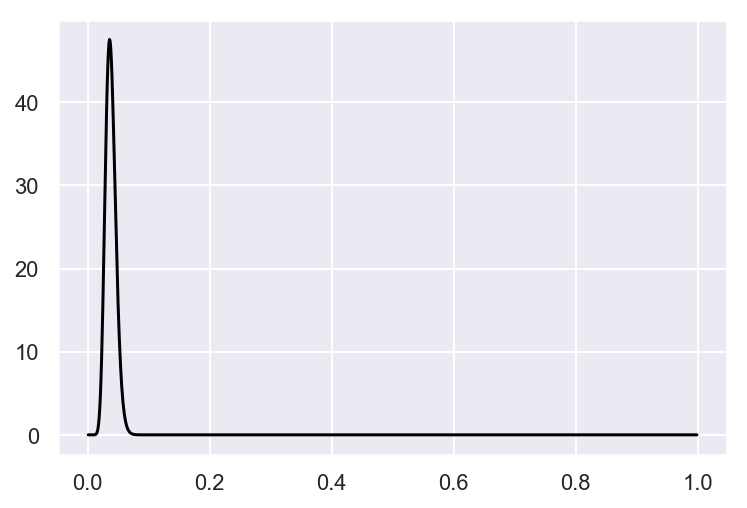

In [55]:
x = np.linspace(0, 1, 1002)[1:-1]
dist = beta(19, 481)
plt.plot(x, dist.pdf(x), c='black',
             label=r'$\alpha=%.1f,\ \beta=%.1f$' % (19, 481))
plt.show()

In [25]:
domain_fraud_wide.head(12)

,Domain_name,safe,fraud,domain_count,fraud_prop,modified_fraud_domain_prop
0,360.cn,10.0,NaN,NaN,NaN,NaN
1,a8.net,56.0,1.0,57.0,0.017544,0.035907
2,alexa.com,4377.0,133.0,4510.0,0.029490,0.030339
3,alibaba.com,227.0,9.0,236.0,0.038136,0.038043
4,amazon.co.jp,6766.0,223.0,6989.0,0.031907,0.032314
5,ameblo.jp,8.0,1.0,9.0,0.111111,0.039293
6,aol.com,4.0,NaN,NaN,NaN,NaN
7,businesswire.com,4.0,NaN,NaN,NaN,NaN
8,cbslocal.com,38.0,2.0,40.0,0.050000,0.038889
9,cbsnews.com,1059.0,58.0,1117.0,0.051925,0.047619


Let's look at the above data carefully. The domain name, ameblo.jp shows up only 9 times. Out of which one is fraud case, resulting in 11 percent fraud. This might give an impression that ameblo.jp is a risky domain. But only 9 cases doesn't give enough confidence. 
So we use Empirical Bayes estimation to get modified fraud percentage, resulting in  around 3 percent, which seems more reasonable.  

In [26]:
fraud_data_2['group_credit']=pd.cut(fraud_data_2['credit_limit'],\
                                  range(1000,5000,300),right=False)


In [27]:
credit_fraud=fraud_data_2.groupby(['group_credit','is_fraud']).agg({'id':'count'})
#credit_fraud_pct=credit_fraud.groupby('group_credit').apply(lambda x: (x / float(x.sum())))
#credit_pcts = credit_fraud_pct.reset_index()
#credit_pcts.head(3)

In [28]:
credit_fraud_wide=credit_fraud.unstack()
credit_fraud_wide.columns=credit_fraud_wide.columns.droplevel(0)
credit_fraud_wide.head(2)

is_fraud,0,1
group_credit,,
"[1000, 1300)",28610,1194
"[1300, 1600)",15499,587


In [29]:
credit_fraud_wide = credit_fraud_wide.reset_index()
credit_fraud_wide.columns.name=None
credit_fraud_wide.head(2)

,group_credit,0,1
0,"[1000, 1300)",28610,1194
1,"[1300, 1600)",15499,587


In [30]:
credit_fraud_wide.rename(columns={0:'safe',1:'fraud'},inplace=True)
credit_fraud_wide['credit_count']=credit_fraud_wide['safe']+credit_fraud_wide['fraud']
credit_fraud_wide['credit_fraud_prop']=credit_fraud_wide['fraud']/credit_fraud_wide['credit_count']

In [31]:
credit_fraud_wide['modified_credit_fraud_prop']=(19+credit_fraud_wide['fraud'])/(19+481+credit_fraud_wide['credit_count'])

In [32]:
credit_fraud_wide.head(12)

,group_credit,safe,fraud,credit_count,credit_fraud_prop,modified_credit_fraud_prop
0,"[1000, 1300)",28610,1194,29804,0.040062,0.040028
1,"[1300, 1600)",15499,587,16086,0.036491,0.036537
2,"[1600, 1900)",8546,359,8905,0.040314,0.040191
3,"[1900, 2200)",4747,175,4922,0.035555,0.035780
4,"[2200, 2500)",2496,95,2591,0.036665,0.036881
5,"[2500, 2800)",1361,56,1417,0.039520,0.039124
6,"[2800, 3100)",773,35,808,0.043317,0.041284
7,"[3100, 3400)",405,13,418,0.031100,0.034858
8,"[3400, 3700)",231,10,241,0.041494,0.039136
9,"[3700, 4000)",119,4,123,0.032520,0.036918


In [33]:
fraud_data_2['group_distance']=pd.cut(fraud_data_2['dist_latest_transaction_address_km'],\
                                  range(0,65,2),right=False)
distance_fraud=fraud_data_2.groupby(['group_distance','is_fraud']).agg({'id':'count'})
distance_fraud_wide=distance_fraud.unstack()
distance_fraud_wide.columns=distance_fraud_wide.columns.droplevel(0)
distance_fraud_wide = distance_fraud_wide.reset_index()
distance_fraud_wide.columns.name=None
distance_fraud_wide.rename(columns={0:'safe',1:'fraud'},inplace=True)
distance_fraud_wide['dist_count']=distance_fraud_wide['safe']+distance_fraud_wide['fraud']
distance_fraud_wide['dist_fraud_prop']=distance_fraud_wide['fraud']/distance_fraud_wide['dist_count']

In [34]:
distance_fraud_wide['modified_dist_fraud_prop']=(19+distance_fraud_wide['fraud'])/(19+481+distance_fraud_wide['dist_count'])
#distance_fraud_wide.head(10)

In [35]:
distance_fraud_wide.sort_values('dist_count',axis=0,ascending=True)

,group_distance,safe,fraud,dist_count,dist_fraud_prop,modified_dist_fraud_prop
20,"[40, 42)",4.0,1.0,5.0,0.200000,0.039604
17,"[34, 36)",17.0,1.0,18.0,0.055556,0.038610
18,"[36, 38)",21.0,2.0,23.0,0.086957,0.040153
16,"[32, 34)",39.0,1.0,40.0,0.025000,0.037037
15,"[30, 32)",52.0,9.0,61.0,0.147541,0.049911
14,"[28, 30)",74.0,8.0,82.0,0.097561,0.046392
13,"[26, 28)",127.0,16.0,143.0,0.111888,0.054432
12,"[24, 26)",155.0,23.0,178.0,0.129213,0.061947
11,"[22, 24)",246.0,27.0,273.0,0.098901,0.059508
10,"[20, 22)",342.0,32.0,374.0,0.085561,0.058352


Similar to the case of Domain names,here we have distance in the range 40-42 km, very rare.

Next, we will join the modified fraud percent columns to original dataset. The  joined data will be used to train the model. 

In [36]:
fraud_credit_joined=pd.merge(left=fraud_data_2,right=credit_fraud_wide,how='left',on='group_credit')
fraud_credit_joined.head(2)

,id,dist_latest_transaction_address_km,email,application_date,site_visits_A,site_visits_B,credit_limit,number_of_transactions,is_fraud,time,day,day_name,Domain_name,group_credit,group_distance,safe,fraud,credit_count,credit_fraud_prop,modified_credit_fraud_prop
0,0,11,lmeechan7i@cbsnews.com,2019-04-23 07:56:50.487770,6,0,1941.32,22,0,7,23,Tue,cbsnews.com,"[1900, 2200)","[10, 12)",4747.0,175.0,4922.0,0.035555,0.035780
1,1,1,nwarkupic@desdev.cn,2019-03-11 17:27:51.857759,36,0,1149.98,17,0,17,11,Mon,desdev.cn,"[1000, 1300)","[0, 2)",28610.0,1194.0,29804.0,0.040062,0.040028


In [37]:
fraud_credit_domain_joined=pd.merge(left=fraud_credit_joined, right= domain_fraud_wide,how='left',on='Domain_name')
fraud_credit_domain_joined.head(2)

,id,dist_latest_transaction_address_km,email,application_date,site_visits_A,site_visits_B,credit_limit,number_of_transactions,is_fraud,time,day,day_name,Domain_name,group_credit,group_distance,safe_x,fraud_x,credit_count,credit_fraud_prop,modified_credit_fraud_prop,safe_y,fraud_y,domain_count,fraud_prop,modified_fraud_domain_prop
0,0,11,lmeechan7i@cbsnews.com,2019-04-23 07:56:50.487770,6,0,1941.32,22,0,7,23,Tue,cbsnews.com,"[1900, 2200)","[10, 12)",4747.0,175.0,4922.0,0.035555,0.035780,1059.0,58.0,1117.0,0.051925,0.047619
1,1,1,nwarkupic@desdev.cn,2019-03-11 17:27:51.857759,36,0,1149.98,17,0,17,11,Mon,desdev.cn,"[1000, 1300)","[0, 2)",28610.0,1194.0,29804.0,0.040062,0.040028,5787.0,162.0,5949.0,0.027231,0.028066


In [38]:
fraud_credit_domain_dist_joined=pd.merge(left=fraud_credit_domain_joined, right=distance_fraud_wide, how='left',on='group_distance')
fraud_credit_domain_dist_joined.head(2)

,id,dist_latest_transaction_address_km,email,application_date,site_visits_A,site_visits_B,credit_limit,number_of_transactions,is_fraud,time,day,day_name,Domain_name,group_credit,group_distance,safe_x,fraud_x,credit_count,credit_fraud_prop,modified_credit_fraud_prop,safe_y,fraud_y,domain_count,fraud_prop,modified_fraud_domain_prop,safe,fraud,dist_count,dist_fraud_prop,modified_dist_fraud_prop
0,0,11,lmeechan7i@cbsnews.com,2019-04-23 07:56:50.487770,6,0,1941.32,22,0,7,23,Tue,cbsnews.com,"[1900, 2200)","[10, 12)",4747.0,175.0,4922.0,0.035555,0.035780,1059.0,58.0,1117.0,0.051925,0.047619,2892.0,158.0,3050.0,0.051803,0.049859
1,1,1,nwarkupic@desdev.cn,2019-03-11 17:27:51.857759,36,0,1149.98,17,0,17,11,Mon,desdev.cn,"[1000, 1300)","[0, 2)",28610.0,1194.0,29804.0,0.040062,0.040028,5787.0,162.0,5949.0,0.027231,0.028066,15955.0,566.0,16521.0,0.034259,0.034369


In [39]:
fraud_credit_domain_dist_joined.columns

Index(['id', 'dist_latest_transaction_address_km', 'email', 'application_date',
       'site_visits_A', 'site_visits_B', 'credit_limit',
       'number_of_transactions', 'is_fraud', 'time', 'day', 'day_name',
       'Domain_name', 'group_credit', 'group_distance', 'safe_x', 'fraud_x',
       'credit_count', 'credit_fraud_prop', 'modified_credit_fraud_prop',
       'safe_y', 'fraud_y', 'domain_count', 'fraud_prop',
       'modified_fraud_domain_prop', 'safe', 'fraud', 'dist_count',
       'dist_fraud_prop', 'modified_dist_fraud_prop'],
      dtype='object')

In [41]:
fraud_credit_domain_dist_joined.drop(['id','dist_latest_transaction_address_km','email','application_date','time','day','safe_x','fraud_x'\
                                ,'safe_y','fraud_y','credit_count','credit_fraud_prop','domain_count','fraud_prop'\
                                ,'dist_count','dist_fraud_prop','safe','fraud','credit_limit','Domain_name','group_credit','day_name','group_distance'\
                                     ],axis=1,inplace=True)
fraud_credit_domain_dist_joined.columns

Index(['site_visits_A', 'site_visits_B', 'number_of_transactions', 'is_fraud',
       'modified_credit_fraud_prop', 'modified_fraud_domain_prop',
       'modified_dist_fraud_prop'],
      dtype='object')

In [42]:
fraud_credit_domain_dist_joined.columns[fraud_credit_domain_dist_joined.isnull().any()]

Index(['modified_credit_fraud_prop', 'modified_fraud_domain_prop',
       'modified_dist_fraud_prop'],
      dtype='object')

In [43]:
fraud_credit_domain_dist_joined['modified_credit_fraud_prop']= fraud_credit_domain_dist_joined['modified_credit_fraud_prop'].fillna(0.03)
fraud_credit_domain_dist_joined['modified_fraud_domain_prop']= fraud_credit_domain_dist_joined['modified_fraud_domain_prop'].fillna(0.03)
fraud_credit_domain_dist_joined['modified_dist_fraud_prop']= fraud_credit_domain_dist_joined['modified_dist_fraud_prop'].fillna(0.03)

In [44]:
fraud_credit_domain_dist_joined.columns[fraud_credit_domain_dist_joined.isnull().any()]

Index([], dtype='object')

In [45]:
y=fraud_credit_domain_dist_joined['is_fraud'].copy()
X=fraud_credit_domain_dist_joined.drop(['is_fraud'],axis=1)
rf_train,rf_test,y_train,y_test = train_test_split(X,y,test_size=0.2,shuffle=True,stratify=y,random_state=0)
rf_train_new,rf_valid,y_train_new,y_valid = train_test_split(rf_train,y_train,\
                                                             test_size=0.3,shuffle=True,stratify=y_train,random_state=0)

In [49]:
answer=optimal_auc(rf_train_new,para_grid,y_train_new,y_valid,rf_valid)

In [50]:
answer


(0.6361237782888204, (5, 'auto', 4))

In [51]:
clf_test = RandomForestClassifier(max_depth= 4, max_features= 'auto', n_estimators= 5,\
                                            random_state=42).fit(rf_train, y_train)

In [63]:
clf_test.feature_importances_

array([0.04167713, 0.09445741, 0.09055996, 0.04292795, 0.36136631,
       0.36901123])

In [52]:
feature_importances = pd.DataFrame(clf_test.feature_importances_,
                                   index = rf_train.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)
feature_importances

,importance
modified_dist_fraud_prop,0.369011
modified_fraud_domain_prop,0.361366
site_visits_B,0.094457
number_of_transactions,0.090560
modified_credit_fraud_prop,0.042928
site_visits_A,0.041677


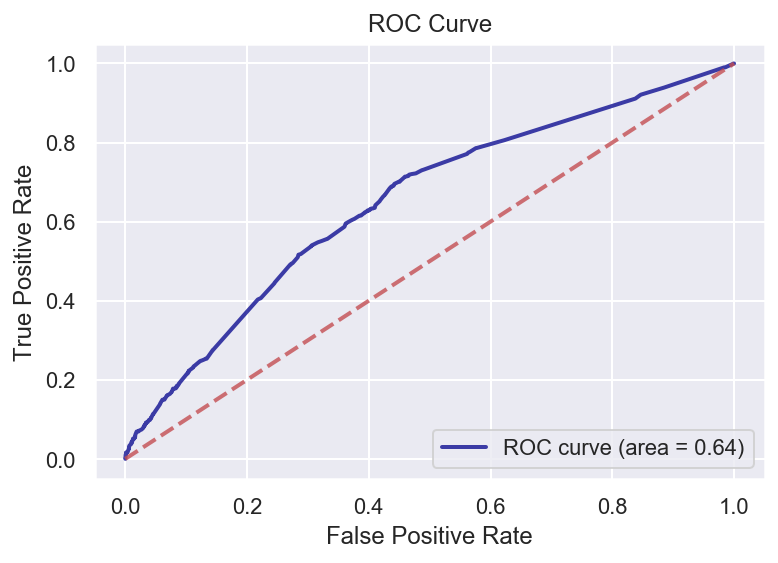

In [53]:
#clf_improved = RandomForestClassifier(max_depth= 6, max_features= 'auto', n_estimators= 5,\
 #                                           random_state=42).fit(rf_train_new, y_train_new)
probab_new=clf_test.predict_proba(rf_valid)
fpr, tpr, thresholds = metrics.roc_curve(np.array(y_valid),np.array(probab_new[:,1]),1)
plt.plot(fpr, tpr, lw=2, alpha=0.75, color='darkblue',label='ROC curve (area = %0.2f)' % answer[0])
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', alpha=.8)
plt.legend(loc="lower right")
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.title("ROC Curve")
plt.show()

In [66]:
rf_valid_new=rf_valid.copy()
rf_valid_new['fraud']=y_valid
rf_valid_new.head(20)

,site_visits_A,site_visits_B,number_of_transactions,modified_credit_fraud_prop,modified_fraud_domain_prop,modified_dist_fraud_prop,fraud
29082,35,1,24,0.040028,0.051910,0.032800,0
26881,6,1,23,0.035780,0.047619,0.032800,0
31031,3,0,20,0.040028,0.049180,0.060829,0
37297,7,1,18,0.036537,0.046784,0.034369,0
54975,12,0,15,0.040028,0.032314,0.033281,0
64421,7,1,18,0.040028,0.047619,0.033281,1
8502,8,1,22,0.041284,0.047619,0.060829,0
41906,3,1,21,0.040191,0.046784,0.032800,0
35562,0,0,20,0.036537,0.049180,0.032800,0
58997,12,1,19,0.041284,0.027503,0.037559,0


In [68]:
rf_valid_new.index=range(len(rf_valid_new))
rf_valid_new.head(10)

,site_visits_A,site_visits_B,number_of_transactions,modified_credit_fraud_prop,modified_fraud_domain_prop,modified_dist_fraud_prop,fraud
0,35,1,24,0.040028,0.051910,0.032800,0
1,6,1,23,0.035780,0.047619,0.032800,0
2,3,0,20,0.040028,0.049180,0.060829,0
3,7,1,18,0.036537,0.046784,0.034369,0
4,12,0,15,0.040028,0.032314,0.033281,0
5,7,1,18,0.040028,0.047619,0.033281,1
6,8,1,22,0.041284,0.047619,0.060829,0
7,3,1,21,0.040191,0.046784,0.032800,0
8,0,0,20,0.036537,0.049180,0.032800,0
9,12,1,19,0.041284,0.027503,0.037559,0


In [69]:
test=pd.DataFrame(probab_new[:,1])
test.head(10)

,0
0,0.045370
1,0.049970
2,0.086833
3,0.051642
4,0.026915
5,0.051642
6,0.085387
7,0.041286
8,0.050668
9,0.023812


In [81]:
test2=pd.concat([rf_valid_new,test],axis=1,join='inner')
test2.shape
#rf_valid_new['pred_prob']=probab_new[:,1]
#rf_valid_new.head(20)

(15713, 8)

In [71]:
#rf_valid_new=rf_valid_new.reindex(index=range(len(rf_valid_new)))
print(rf_valid_new.shape)
print(test.shape)

(15713, 7)
(15713, 1)


In [75]:
test2.columns

Index([             'site_visits_A',              'site_visits_B',
           'number_of_transactions', 'modified_credit_fraud_prop',
       'modified_fraud_domain_prop',   'modified_dist_fraud_prop',
                            'fraud',                            0],
      dtype='object')

In [82]:
test2.rename(columns={0:'pred_prob'},inplace=True)
#test2.sort_values(by=[])
test2.head(3)

,site_visits_A,site_visits_B,number_of_transactions,modified_credit_fraud_prop,modified_fraud_domain_prop,modified_dist_fraud_prop,fraud,pred_prob
0,35,1,24,0.040028,0.051910,0.032800,0,0.045370
1,6,1,23,0.035780,0.047619,0.032800,0,0.049970
2,3,0,20,0.040028,0.049180,0.060829,0,0.086833


In [83]:
test2.sort_values(by=['fraud','pred_prob'],ascending=[True,False],inplace=True)
#test2.head(20)

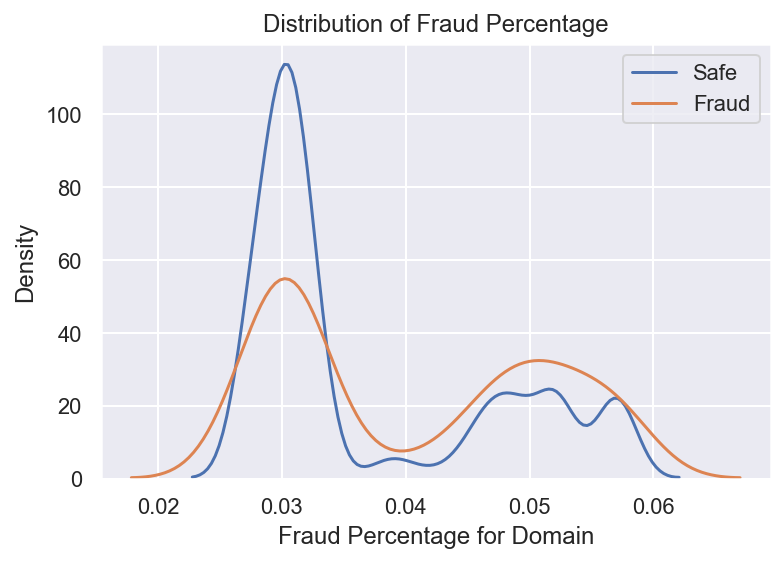

In [117]:
df = test2[test2['fraud'] == 0]
ax1=sns.distplot(df['modified_fraud_domain_prop'], hist=False, kde = True, label='Safe')
df = test2[test2['fraud'] == 1]
ax1=sns.distplot(df['modified_fraud_domain_prop'], hist=False, kde = True, label='Fraud')
# Plot formatting
#plt.legend(prop={'size': 12})
ax1.set_title('Distribution of Fraud Percentage')
ax1.set_xlabel('Fraud Percentage for Domain')
ax1.set_ylabel('Density')
plt.show()

In [121]:
print(df1.shape)

(608, 8)


### Decision Trees
Another approach to judge feature importance is by growing a quite deep tree and then look at the contribution made by each feature. The contribution made is identical to reduction in entropy with each split.

In [60]:
fraud_credit_domain_joined.dtypes

dist_latest_transaction_address_km      int64
site_visits_A                           int64
site_visits_B                           int64
number_of_transactions                  int64
is_fraud                                int64
day_name                               object
modified_credit_fraud_prop            float64
modified_fraud_domain_prop            float64
dtype: object

In [42]:
rf_train_new=pd.get_dummies(rf_train_new,drop_first=True)
rf_train_new.head(4)

,dist_latest_transaction_address_km,site_visits_A,site_visits_B,number_of_transactions,modified_credit_fraud_prop,modified_fraud_domain_prop
50644,5,4,0,14,0.039983,0.056281
7498,4,18,0,23,0.039983,0.028079
23179,2,3,1,22,0.036481,0.030441
25060,5,1,0,20,0.039983,0.030441


In [43]:

clf = DecisionTreeClassifier(random_state=0)
clf=clf.fit(rf_train_new,y_train_new)

In [85]:
clf.get_params

<bound method DecisionTreeClassifier.get_params of DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best')>

In [101]:
feature_importances_decision_tree = pd.DataFrame(clf.feature_importances_,
                                   index = rf_train_new.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)
feature_importances_decision_tree

,importance
number_of_transactions,0.218848
modified_fraud_domain_prop,0.214806
site_visits_A,0.212569
dist_latest_transaction_address_km,0.141113
modified_credit_fraud_prop,0.118341
site_visits_B,0.094323


Now that we have got a very deep tree, we will do the predictions on validation set and check the area under the ROC curve.

In [79]:
rf_valid=pd.get_dummies(rf_valid,drop_first=True)
rf_valid.head(2)

,dist_latest_transaction_address_km,site_visits_A,site_visits_B,number_of_transactions,modified_credit_fraud_prop,modified_fraud_domain_prop,day_name_Mon,day_name_Sat,day_name_Sun,day_name_Thu,day_name_Tue,day_name_Wed
35880,3,2,1,19,0.040221,0.027517,0,0,0,0,1,0
7608,10,21,2,21,0.039124,0.029812,0,0,1,0,0,0


In [102]:
predicted_probs_decision_tree=clf.predict_proba(rf_valid)
predicted_probs_decision_tree.shape

(15706, 2)

In [103]:
roc_auc_decision_tree=metrics.roc_auc_score(np.array(y_valid),np.array(predicted_probs_decision_tree[:,1]))
roc_auc_decision_tree

0.5074311302678542

But the AUC is considerably lower for Decision trees as compared to Random Forests. 

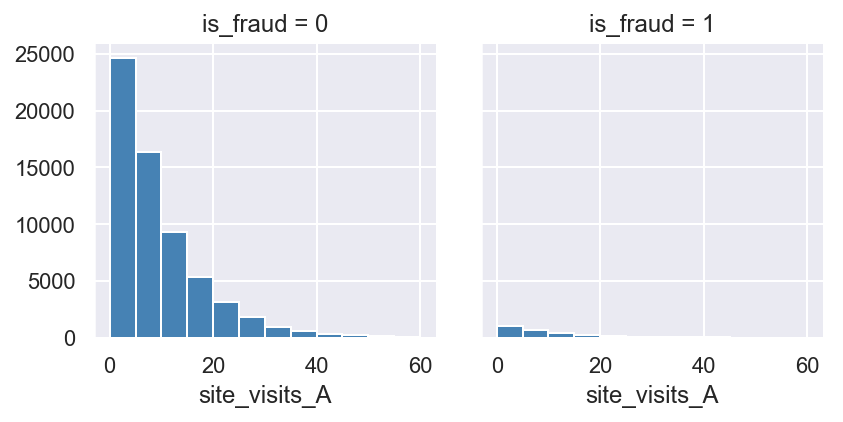

In [95]:
g = sns.FacetGrid(fraud_data, col="is_fraud", margin_titles=True)
bins = np.linspace(0, 60, 13)
g.map(plt.hist, "site_visits_A", color="steelblue", bins=bins)
plt.show()

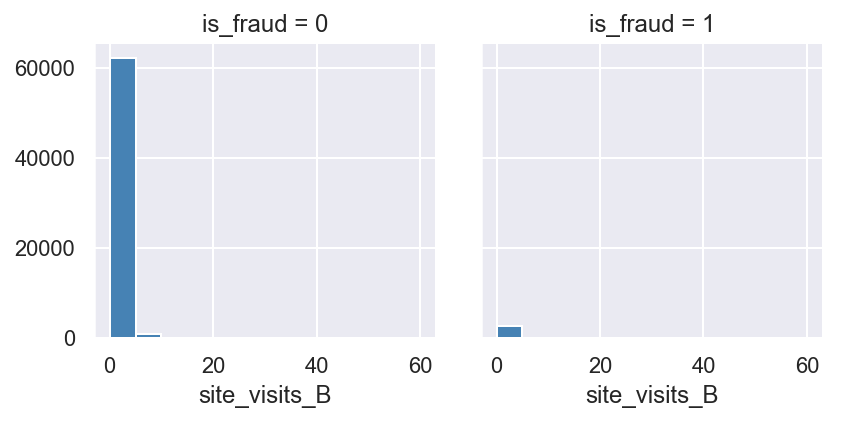

In [96]:
g = sns.FacetGrid(fraud_data, col="is_fraud", margin_titles=True)
bins = np.linspace(0, 60, 13)
g.map(plt.hist, "site_visits_B", color="steelblue", bins=bins)
plt.show()

In [78]:
y_train_new.shape

(36646,)

In [98]:
rf_train_new.drop(['day_name_Mon', 'day_name_Sat', 'day_name_Sun', 'day_name_Thu','day_name_Tue', 'day_name_Wed'],axis=1,inplace=True)
rf_train_new.columns

Index([u'dist_latest_transaction_address_km', u'site_visits_A',
       u'site_visits_B', u'number_of_transactions',
       u'modified_credit_fraud_prop', u'modified_fraud_domain_prop'],
      dtype='object')

In [99]:
rf_valid.drop(['day_name_Mon', 'day_name_Sat', 'day_name_Sun', 'day_name_Thu','day_name_Tue', 'day_name_Wed'],axis=1,inplace=True)
rf_valid.columns

Index([u'dist_latest_transaction_address_km', u'site_visits_A',
       u'site_visits_B', u'number_of_transactions',
       u'modified_credit_fraud_prop', u'modified_fraud_domain_prop'],
      dtype='object')

### Logistic Regression
Earlier, we saw that the best AUC obtained using Random Forests is 0.64, which is not very high. In this section, we attempt Logistic Regression.  We will use the similar set of features; fraud percent corresponding to Domain name, credit limit, and Distance between place of transaction and credit application.

In [128]:
clf_logit = LogisticRegression(penalty='l2',random_state=0, solver='sag',
                         multi_class='ovr').fit(rf_train, y_train)

In [129]:
probab_logit=clf_logit.predict_proba(rf_valid)

In [131]:
rf_train.columns

Index([u'dist_latest_transaction_address_km', u'site_visits_A',
       u'site_visits_B', u'number_of_transactions',
       u'modified_credit_fraud_prop', u'modified_fraud_domain_prop'],
      dtype='object')

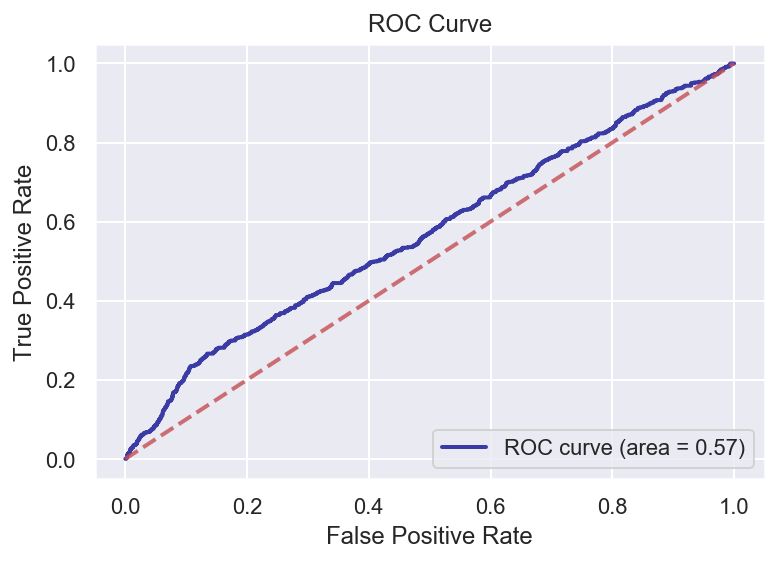

In [130]:
fpr, tpr, thresholds = metrics.roc_curve(np.array(y_valid),np.array(probab_logit[:,1]),1)
plt.plot(fpr, tpr, lw=2, alpha=0.75, color='darkblue',label='ROC curve (area = %0.2f)' % metrics.roc_auc_score(np.array(y_valid),np.array(probab_logit[:,1])))
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', alpha=.8)
plt.legend(loc="lower right")
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.title("ROC Curve")
plt.show()

In [92]:
pip install graphviz

SyntaxError: invalid syntax (<ipython-input-92-e29701ab7d5b>, line 1)